# Filter für minimalistische Logos (Complete Dataset - Batch Processing)

Dieses Notebook analysiert ALLE Logos aus dem total_after_cleanup Ordner und filtert minimalistische Designs basierend auf:
- Farbkomplexität (Anzahl einzigartiger Farben)
- Kantenkomplexität (Anzahl der Kanten)
- Formkomplexität (Anzahl der Konturen)
- Weißraum-Anteil
- Detailgrad

**Batch-Processing Features:**
- Verarbeitet große Datenmengen in 10k-Batches
- Speichert Fortschritt in metadata.json
- Automatische Wiederaufnahme bei Unterbrechung
- Minimalistische Logos werden in den Ordner `total_filtered` kopiert

In [1]:
import sys
from pathlib import Path

utils_path = Path('../../utils')
sys.path.append(str(utils_path))

from images import (
    analyze_color_complexity,
    analyze_edge_complexity,
    analyze_shape_complexity,
    analyze_whitespace,
    analyze_logo_row
)

In [2]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
import json
import shutil
from pandarallel import pandarallel
from parallel_pandas import ParallelPandas
import time

# Pandarallel initialisieren
ParallelPandas.initialize(n_cpu=15)

# BATCH PROCESSING CONFIGURATION
BATCH_SIZE = 10000  # Logos pro Batch
SAVE_PROGRESS_EVERY = 1000  # Speichere Zwischenergebnisse alle X Logos

# Pfade definieren
base_path = Path('../../output/amazing_logos_v4')
source_images_path = base_path / 'images' / 'total_after_cleanup'
filtered_images_path = base_path / 'images' / 'total_filtered'
results_path = base_path / 'analysis'
progress_file = results_path / 'batch_processing_metadata.json'

# Ordner erstellen falls nicht vorhanden
filtered_images_path.mkdir(parents=True, exist_ok=True)
results_path.mkdir(exist_ok=True)

print(f"🔍 Analysiere ALLE Logos in: {source_images_path}")
print(f"✅ Gefilterte minimalistische Logos werden kopiert nach: {filtered_images_path}")
print(f"📊 Batch-Größe: {BATCH_SIZE:,} Logos")
print(f"💾 Fortschritt wird gespeichert in: {progress_file}")

# PNG Dateien aus total_after_cleanup suchen
logo_files = list(source_images_path.glob('*.png'))
total_logos = len(logo_files)
total_batches = (total_logos + BATCH_SIZE - 1) // BATCH_SIZE  # Ceil division

print(f"\n📈 DATASET OVERVIEW:")
print(f"  Gefunden: {total_logos:,} Logos")
print(f"  Batch-Größe: {BATCH_SIZE:,}")
print(f"  Total Batches: {total_batches}")
print(f"  Geschätzte Verarbeitungszeit: {total_batches * 5}-{total_batches * 15} Minuten")

c:\Users\paul-\miniconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Analysiere ALLE Logos in: ..\..\output\amazing_logos_v4\images\total_after_cleanup
✅ Gefilterte minimalistische Logos werden kopiert nach: ..\..\output\amazing_logos_v4\images\total_filtered
📊 Batch-Größe: 10,000 Logos
💾 Fortschritt wird gespeichert in: ..\..\output\amazing_logos_v4\analysis\batch_processing_metadata.json

📈 DATASET OVERVIEW:
  Gefunden: 352,154 Logos
  Batch-Größe: 10,000
  Total Batches: 36
  Geschätzte Verarbeitungszeit: 180-540 Minuten


In [3]:
# PROGRESS TRACKING SYSTEM
def load_progress():
    """Lade gespeicherten Fortschritt oder erstelle neuen"""
    if progress_file.exists():
        with open(progress_file, 'r') as f:
            progress = json.load(f)
        print(f"📂 Fortschritt geladen: Batch {progress['current_batch']}/{progress['total_batches']}")
        print(f"   Bereits verarbeitet: {progress['processed_logos']:,} Logos")
        print(f"   Bereits gefiltert: {progress['filtered_logos']:,} Logos")
        return progress
    else:
        progress = {
            'total_logos': total_logos,
            'total_batches': total_batches,
            'current_batch': 0,
            'processed_logos': 0,
            'filtered_logos': 0,
            'completed_batches': [],
            'start_time': time.time(),
            'last_update': time.time(),
            'analysis_results': []
        }
        print("🆕 Neuer Fortschritt erstellt")
        return progress

def save_progress(progress):
    """Speichere aktuellen Fortschritt"""
    progress['last_update'] = time.time()
    with open(progress_file, 'w') as f:
        json.dump(progress, f, indent=2)

def cleanup_old_cumulative_files(keep_last_n=3):
    """Lösche alte kumulative Dateien und behalte nur die letzten N"""
    cumulative_files = sorted(results_path.glob('cumulative_analysis_through_batch_*.csv'))
    if len(cumulative_files) > keep_last_n:
        files_to_delete = cumulative_files[:-keep_last_n]
        for file_to_delete in files_to_delete:
            try:
                file_to_delete.unlink()
                print(f"   🗑️ Alte kumulative Datei gelöscht: {file_to_delete.name}")
            except Exception as e:
                print(f"   ⚠️ Fehler beim Löschen von {file_to_delete.name}: {e}")

def get_batch_files(batch_num, all_files, batch_size):
    """Hole Dateien für einen bestimmten Batch"""
    start_idx = batch_num * batch_size
    end_idx = min(start_idx + batch_size, len(all_files))
    return all_files[start_idx:end_idx]

def calculate_eta(progress):
    """Berechne geschätzte Restzeit"""
    if progress['current_batch'] == 0:
        return "Unbekannt"
    
    elapsed = time.time() - progress['start_time']
    avg_time_per_batch = elapsed / max(progress['current_batch'], 1)
    remaining_batches = progress['total_batches'] - progress['current_batch']
    eta_seconds = remaining_batches * avg_time_per_batch
    
    if eta_seconds < 60:
        return f"{eta_seconds:.0f} Sekunden"
    elif eta_seconds < 3600:
        return f"{eta_seconds/60:.1f} Minuten"
    else:
        return f"{eta_seconds/3600:.1f} Stunden"

# Fortschritt laden
progress = load_progress()

# Status anzeigen
if progress['current_batch'] > 0:
    completion_percent = (progress['current_batch'] / progress['total_batches']) * 100
    print(f"\n🎯 FORTSCHRITT: {completion_percent:.1f}% abgeschlossen")
    print(f"⏱️  Geschätzte Restzeit: {calculate_eta(progress)}")
    
    if progress['current_batch'] == progress['total_batches']:
        print("✅ ALLE BATCHES BEREITS ABGESCHLOSSEN!")
        print("   Führe die Analyse-Zellen aus um Ergebnisse anzuzeigen.")
else:
    print("\n🚀 BEREIT FÜR VERARBEITUNG")

save_progress(progress)

📂 Fortschritt geladen: Batch 36/36
   Bereits verarbeitet: 352,154 Logos
   Bereits gefiltert: 146,077 Logos

🎯 FORTSCHRITT: 100.0% abgeschlossen
⏱️  Geschätzte Restzeit: 0 Sekunden
✅ ALLE BATCHES BEREITS ABGESCHLOSSEN!
   Führe die Analyse-Zellen aus um Ergebnisse anzuzeigen.


## Batch Processing & Performance-Optimierung

Dieses Notebook verwendet **Batch-Processing** für große Datenmengen:

- **Batch-Größe**: 10.000 Logos pro Batch
- **Fortschritt-Tracking**: Automatisches Speichern und Laden des Fortschritts
- **Wiederaufnahme**: Bei Unterbrechung wird automatisch an der richtigen Stelle fortgesetzt
- **pandarallel**: Stabile Parallelisierung mit pandas DataFrames
- **Kernel-sicher**: Funktioniert zuverlässig in Jupyter ohne Kernel-Crashes

**Geschätzte Verarbeitungszeit**:
- ~10.000 Logos: 5-15 Minuten pro Batch
- ~50.000 Logos: 25-75 Minuten total
- ~100.000 Logos: 50-150 Minuten total

**Tipps für bessere Performance**:
- Standard 4 Worker sind meist optimal für Batch-Processing
- Fortschritt wird automatisch gespeichert - keine Sorge bei Unterbrechungen
- Bei Problemen: Kernel neu starten und Notebook erneut ausführen

In [4]:
# Test mit einem Logo
if len(logo_files) > 0:
    test_logo = logo_files[0]
    print(f"Test mit: {test_logo.name}")
    print("Farbkomplexität:", analyze_color_complexity(test_logo))
    print("Kantenkomplexität:", analyze_edge_complexity(test_logo))
    print("Formkomplexität:", analyze_shape_complexity(test_logo))
    print("Weißraum:", analyze_whitespace(test_logo))

Test mit: amazing_logo_v4000000.png


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\paul-\miniconda3\envs\py311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\paul-\miniconda3\envs\py311\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\paul-\miniconda3\envs\py311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\paul-\miniconda3\envs\py311\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 109: invalid start byte


Farbkomplexität: {'unique_colors': 256, 'dominant_colors': np.int64(2), 'color_variance': np.float64(9432.68391656503)}
Kantenkomplexität: {'edge_pixels': np.int64(2539), 'edge_ratio': np.float64(0.0387420654296875), 'edge_density': np.float64(0.0387420654296875)}
Formkomplexität: {'num_contours': 1, 'total_contour_length': 1020.0, 'largest_contour_complexity': 0.00392156862745098}
Weißraum: {'whitespace_ratio': np.float64(0.801788330078125), 'content_ratio': np.float64(0.198211669921875)}


In [5]:
# BATCH PROCESSING MAIN LOOP
def process_batch(batch_files, batch_num, progress):
    """Verarbeite einen Batch von Logo-Dateien"""
    print(f"\n🔄 VERARBEITE BATCH {batch_num + 1}/{progress['total_batches']}")
    print(f"   Logos in diesem Batch: {len(batch_files):,}")
    
    # DataFrame für diesen Batch erstellen
    df_batch = pd.DataFrame({
        'logo_path': batch_files,
        'logo_id': [p.stem for p in batch_files],
        'filename': [p.name for p in batch_files]
    })
    
    # Parallel analysis für diesen Batch mit pandarallel
    print(f"   Starte Analyse...")
    
    analysis_results = df_batch.p_apply(analyze_logo_row, axis=1)
    
    # Kombiniere mit Original-DataFrame
    batch_analysis = pd.concat([df_batch, analysis_results], axis=1)
    
    print(f"   ✅ Batch {batch_num + 1} analysiert")
    
    return batch_analysis

# HAUPTVERARBEITUNG
all_analysis_results = []

# Starte ab dem aktuellen Batch
start_batch = progress['current_batch']
print(f"\n🚀 STARTE BATCH-VERARBEITUNG AB BATCH {start_batch + 1}")

for batch_num in range(start_batch, total_batches):
    print(f"\n" + "="*60)
    print(f"📦 BATCH {batch_num + 1}/{total_batches}")
    
    # Batch-Dateien holen
    batch_files = get_batch_files(batch_num, logo_files, BATCH_SIZE)
    
    # Batch verarbeiten
    batch_time = 0  # Initialize batch_time for error handling
    try:
        batch_start_time = time.time()
        batch_analysis = process_batch(batch_files, batch_num, progress)
        batch_time = time.time() - batch_start_time  # Calculate actual batch time
        all_analysis_results.append(batch_analysis)
        
        # Performance logging
        print(f"   ✅ Batch {batch_num + 1} abgeschlossen in {batch_time:.1f} Sekunden")
        print(f"   ⚡ Performance: {len(batch_files)/batch_time:.1f} Logos/Sekunde")
        
        # Fortschritt aktualisieren
        progress['current_batch'] = batch_num + 1
        progress['processed_logos'] += len(batch_files)
        progress['completed_batches'].append(batch_num)
        
        # Zwischenergebnisse speichern
        batch_file = results_path / f'batch_{batch_num + 1:03d}_analysis.csv'
        batch_analysis.to_csv(batch_file, index=False)
        print(f"   💾 Batch-Ergebnisse gespeichert: {batch_file.name}")
        
        # Zusätzlich: Kumulative Analyse bis zu diesem Batch speichern
        if len(all_analysis_results) > 0:
            cumulative_df = pd.concat(all_analysis_results, ignore_index=True)
            cumulative_file = results_path / f'cumulative_analysis_through_batch_{batch_num + 1:03d}.csv'
            cumulative_df.to_csv(cumulative_file, index=False)
            print(f"   📊 Kumulative Analyse gespeichert: {cumulative_file.name} ({len(cumulative_df):,} Logos)")
            
            # Alte kumulative Dateien aufräumen (behalte nur die letzten 3)
            if (batch_num + 1) % 5 == 0:  # Aufräumen alle 5 Batches
                cleanup_old_cumulative_files(keep_last_n=3)
        
        # Fortschritt mit zusätzlichen Details speichern
        progress['last_batch_file'] = str(batch_file)
        progress['batch_statistics'] = {
            'batch_size': len(batch_files),
            'processing_time': batch_time,
            'logos_per_second': len(batch_files) / batch_time if batch_time > 0 else 0
        }
        save_progress(progress)
        
        # Status-Update
        completion = (batch_num + 1) / total_batches * 100
        eta = calculate_eta(progress)
        print(f"   📊 Gesamtfortschritt: {completion:.1f}% | ETA: {eta}")
        
    except Exception as e:
        print(f"   ❌ FEHLER in Batch {batch_num + 1}: {e}")
        print(f"   💾 Fortschritt gespeichert. Neustart möglich ab Batch {batch_num + 1}")
        
        # Zusätzliche Error-Recovery-Informationen speichern
        progress['last_error'] = {
            'batch': batch_num + 1,
            'error_message': str(e),
            'timestamp': time.time(),
            'processed_files_in_batch': len(batch_files) if 'batch_files' in locals() else 0
        }
        save_progress(progress)
        
        # Versuche die bis hierhin verarbeiteten Batches zu speichern
        if all_analysis_results:
            try:
                emergency_df = pd.concat(all_analysis_results, ignore_index=True)
                emergency_file = results_path / f'emergency_save_through_batch_{batch_num}.csv'
                emergency_df.to_csv(emergency_file, index=False)
                print(f"   🆘 Emergency-Save erstellt: {emergency_file.name} ({len(emergency_df):,} Logos)")
            except Exception as save_error:
                print(f"   ⚠️ Emergency-Save fehlgeschlagen: {save_error}")
        
        raise

print(f"\n🎉 ALLE BATCHES ABGESCHLOSSEN!")
print(f"   Total verarbeitete Logos: {progress['processed_logos']:,}")

# Kombiniere alle Batch-Ergebnisse
if all_analysis_results:
    print(f"\n📊 Kombiniere {len(all_analysis_results)} Batch-Ergebnisse...")
    analysis_df = pd.concat(all_analysis_results, ignore_index=True)
    
    # Vollständige Analyse speichern
    analysis_df.to_csv(results_path / 'complete_analysis_all_logos.csv', index=False)
    print(f"✅ Vollständige Analyse gespeichert: complete_analysis_all_logos.csv")
    print(f"   Total analysierte Logos: {len(analysis_df):,}")
else:
    print("⚠️  Keine neuen Batch-Ergebnisse - lade vorhandene Daten...")
    # Lade vorhandene Batch-Dateien
    batch_files_results = list(results_path.glob('batch_*_analysis.csv'))
    if batch_files_results:
        print(f"📂 Lade {len(batch_files_results)} Batch-Dateien...")
        batch_dfs = []
        for batch_file in sorted(batch_files_results):
            batch_df = pd.read_csv(batch_file)
            batch_dfs.append(batch_df)
        analysis_df = pd.concat(batch_dfs, ignore_index=True)
        print(f"✅ Kombinierte Analyse geladen: {len(analysis_df):,} Logos")
    else:
        print("❌ Keine Batch-Dateien gefunden!")
        analysis_df = pd.DataFrame()


🚀 STARTE BATCH-VERARBEITUNG AB BATCH 37

🎉 ALLE BATCHES ABGESCHLOSSEN!
   Total verarbeitete Logos: 352,154
⚠️  Keine neuen Batch-Ergebnisse - lade vorhandene Daten...
📂 Lade 36 Batch-Dateien...
✅ Kombinierte Analyse geladen: 352,154 Logos


In [6]:
# Minimalismus-Score für das komplette Dataset berechnen
def calculate_minimalism_score(df):
    """Berechnet einen Minimalismus-Score (0-100, höher = minimalistischer)"""
    
    if len(df) == 0:
        print("❌ Keine Daten für Score-Berechnung verfügbar!")
        return pd.Series()
    
    print(f"📊 Berechne Minimalismus-Score für {len(df):,} Logos...")
    
    # Normalisierung der Metriken (0-1)
    # Weniger Farben = minimalistischer
    color_score = 1 - (df['dominant_colors'] - df['dominant_colors'].min()) / (df['dominant_colors'].max() - df['dominant_colors'].min() + 1e-8)
    
    # Weniger Kanten = minimalistischer
    edge_score = 1 - (df['edge_ratio'] - df['edge_ratio'].min()) / (df['edge_ratio'].max() - df['edge_ratio'].min() + 1e-8)
    
    # Weniger Konturen = minimalistischer
    contour_score = 1 - (df['num_contours'] - df['num_contours'].min()) / (df['num_contours'].max() - df['num_contours'].min() + 1e-8)
    
    # Mehr Weißraum = minimalistischer
    whitespace_score = (df['whitespace_ratio'] - df['whitespace_ratio'].min()) / (df['whitespace_ratio'].max() - df['whitespace_ratio'].min() + 1e-8)
    
    # Weniger Farbvarianz = minimalistischer
    variance_score = 1 - (df['color_variance'] - df['color_variance'].min()) / (df['color_variance'].max() - df['color_variance'].min() + 1e-8)
    
    # Gewichteter Score (angepasst für große Datasets)
    minimalism_score = (
        color_score * 0.25 +          # 25% Gewicht für Farben
        edge_score * 0.35 +           # 35% Gewicht für Kanten (wichtigster Faktor)
        contour_score * 0.20 +        # 20% Gewicht für Konturen
        whitespace_score * 0.10 +     # 10% Gewicht für Weißraum
        variance_score * 0.10         # 10% Gewicht für Farbvarianz
    ) * 100
    
    return minimalism_score

# Score berechnen falls Daten vorhanden
if 'analysis_df' in locals() and len(analysis_df) > 0:
    print(f"\n🔢 SCORE-BERECHNUNG")
    analysis_df['minimalism_score'] = calculate_minimalism_score(analysis_df)
    
    # Nach Score sortieren
    analysis_df_sorted = analysis_df.sort_values('minimalism_score', ascending=False)
    
    # Statistiken
    print(f"\n📈 MINIMALISMUS-SCORE STATISTIKEN:")
    score_stats = analysis_df['minimalism_score'].describe()
    for stat, value in score_stats.items():
        print(f"   {stat}: {value:.2f}")
    
    print(f"\n🏆 TOP 10 MINIMALISTISCHE LOGOS:")
    top_10 = analysis_df_sorted[['logo_id', 'minimalism_score', 'dominant_colors', 'edge_ratio', 'whitespace_ratio']].head(10)
    for idx, row in top_10.iterrows():
        print(f"   {row['logo_id']}: Score {row['minimalism_score']:.1f} | Colors: {row['dominant_colors']} | Edges: {row['edge_ratio']:.3f}")
    
    print(f"\n📉 TOP 10 KOMPLEXE LOGOS:")
    bottom_10 = analysis_df_sorted[['logo_id', 'minimalism_score', 'dominant_colors', 'edge_ratio', 'whitespace_ratio']].tail(10)
    for idx, row in bottom_10.iterrows():
        print(f"   {row['logo_id']}: Score {row['minimalism_score']:.1f} | Colors: {row['dominant_colors']} | Edges: {row['edge_ratio']:.3f}")
    
    # Aktualisierte Analyse speichern
    analysis_df_sorted.to_csv(results_path / 'complete_analysis_with_scores.csv', index=False)
    print(f"\n💾 Analyse mit Scores gespeichert: complete_analysis_with_scores.csv")
    
else:
    print("❌ Keine Analysedaten für Score-Berechnung verfügbar!")
    print("   Führe zuerst die Batch-Verarbeitung aus.")


🔢 SCORE-BERECHNUNG
📊 Berechne Minimalismus-Score für 352,154 Logos...

📈 MINIMALISMUS-SCORE STATISTIKEN:
   count: 352154.00
   mean: 79.63
   std: 11.40
   min: 22.74
   25%: 70.77
   50%: 82.16
   75%: 88.91
   max: 99.99

🏆 TOP 10 MINIMALISTISCHE LOGOS:
   amazing_logo_v4057493: Score 100.0 | Colors: 1.0 | Edges: 0.000
   amazing_logo_v4247093: Score 100.0 | Colors: 1.0 | Edges: 0.000
   amazing_logo_v4138616: Score 100.0 | Colors: 1.0 | Edges: 0.000
   amazing_logo_v4233901: Score 100.0 | Colors: 1.0 | Edges: 0.000
   amazing_logo_v4335063: Score 99.8 | Colors: 1.0 | Edges: 0.002
   amazing_logo_v4259561: Score 99.8 | Colors: 1.0 | Edges: 0.002
   amazing_logo_v4288441: Score 99.7 | Colors: 1.0 | Edges: 0.003
   amazing_logo_v4221859: Score 99.6 | Colors: 1.0 | Edges: 0.004
   amazing_logo_v4168571: Score 99.6 | Colors: 1.0 | Edges: 0.004
   amazing_logo_v4196077: Score 99.5 | Colors: 1.0 | Edges: 0.005

📉 TOP 10 KOMPLEXE LOGOS:
   amazing_logo_v4077890: Score 35.2 | Colors: 10.0 

In [7]:
analysis_df_sorted[analysis_df_sorted['logo_id'] == 'logowiz000078']

,logo_path,logo_id,filename,unique_colors,dominant_colors,color_variance,edge_pixels,edge_ratio,edge_density,num_contours,total_contour_length,largest_contour_complexity,whitespace_ratio,content_ratio,minimalism_score


In [8]:
analysis_df_sorted[analysis_df_sorted['logo_id'] == 'logowiz000168']

,logo_path,logo_id,filename,unique_colors,dominant_colors,color_variance,edge_pixels,edge_ratio,edge_density,num_contours,total_contour_length,largest_contour_complexity,whitespace_ratio,content_ratio,minimalism_score


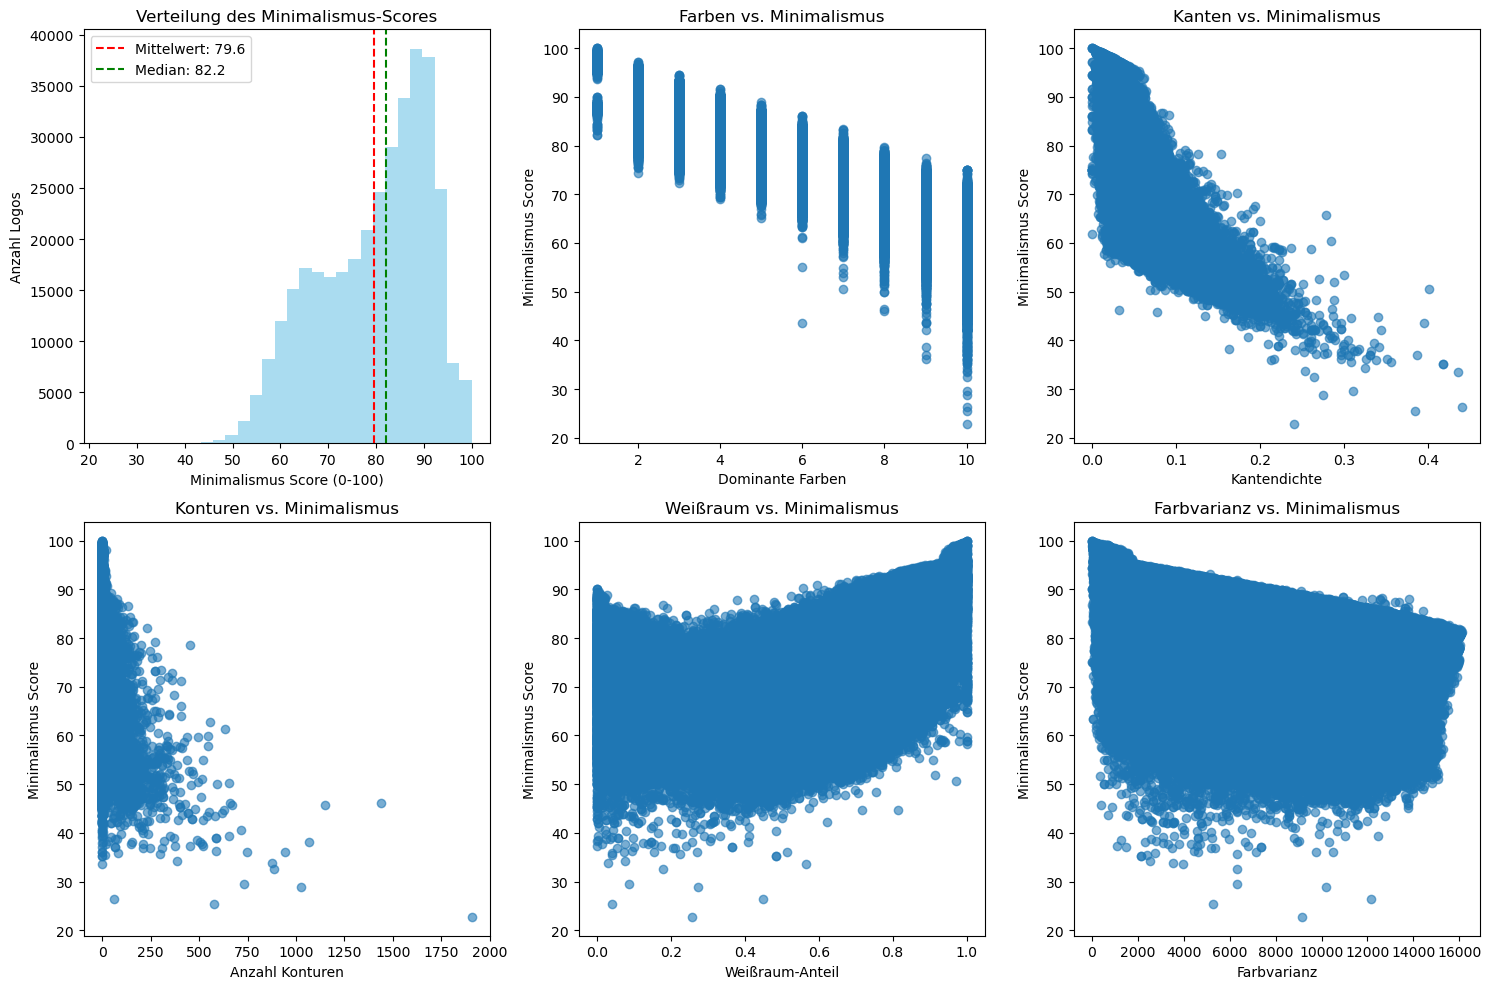

In [9]:
# Minimalismus-Score visualisieren
plt.figure(figsize=(15, 10))

# Score-Verteilung
plt.subplot(2, 3, 1)
plt.hist(analysis_df['minimalism_score'], bins=30, alpha=0.7, color='skyblue')
plt.axvline(analysis_df['minimalism_score'].mean(), color='red', linestyle='--', 
            label=f'Mittelwert: {analysis_df["minimalism_score"].mean():.1f}')
plt.axvline(analysis_df['minimalism_score'].median(), color='green', linestyle='--', 
            label=f'Median: {analysis_df["minimalism_score"].median():.1f}')
plt.title('Verteilung des Minimalismus-Scores')
plt.xlabel('Minimalismus Score (0-100)')
plt.ylabel('Anzahl Logos')
plt.legend()

# Farben vs. Score
plt.subplot(2, 3, 2)
plt.scatter(analysis_df['dominant_colors'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Dominante Farben')
plt.ylabel('Minimalismus Score')
plt.title('Farben vs. Minimalismus')

# Kanten vs. Score
plt.subplot(2, 3, 3)
plt.scatter(analysis_df['edge_ratio'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Kantendichte')
plt.ylabel('Minimalismus Score')
plt.title('Kanten vs. Minimalismus')

# Konturen vs. Score
plt.subplot(2, 3, 4)
plt.scatter(analysis_df['num_contours'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Anzahl Konturen')
plt.ylabel('Minimalismus Score')
plt.title('Konturen vs. Minimalismus')

# Weißraum vs. Score
plt.subplot(2, 3, 5)
plt.scatter(analysis_df['whitespace_ratio'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Weißraum-Anteil')
plt.ylabel('Minimalismus Score')
plt.title('Weißraum vs. Minimalismus')

# Farbvarianz vs. Score
plt.subplot(2, 3, 6)
plt.scatter(analysis_df['color_variance'], analysis_df['minimalism_score'], alpha=0.6)
plt.xlabel('Farbvarianz')
plt.ylabel('Minimalismus Score')
plt.title('Farbvarianz vs. Minimalismus')

plt.tight_layout()
plt.savefig(results_path / 'balanced_sample_minimalism_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Schwellenwert definieren und minimalistische Logos identifizieren
if 'analysis_df_sorted' in locals() and len(analysis_df_sorted) > 0:
    print(f"🎯 LOGO-KLASSIFIZIERUNG")
    
    threshold_percentile = 50  # Obere 50% als minimalistisch
    minimalism_threshold = np.percentile(analysis_df_sorted['minimalism_score'], threshold_percentile)
    
    print(f"   Minimalismus-Schwellenwert ({threshold_percentile}. Perzentil): {minimalism_threshold:.1f}")
    
    # Logos klassifizieren
    minimalistic_logos = analysis_df_sorted[analysis_df_sorted['minimalism_score'] >= minimalism_threshold]
    non_minimalistic_logos = analysis_df_sorted[analysis_df_sorted['minimalism_score'] < minimalism_threshold]
    
    print(f"\n📊 KLASSIFIZIERUNG RESULTS:")
    print(f"   Total analysierte Logos: {len(analysis_df_sorted):,}")
    print(f"   Minimalistische Logos: {len(minimalistic_logos):,} ({len(minimalistic_logos)/len(analysis_df_sorted)*100:.1f}%)")
    print(f"   Komplexe Logos: {len(non_minimalistic_logos):,} ({len(non_minimalistic_logos)/len(analysis_df_sorted)*100:.1f}%)")
    
    # Score-Verteilung
    print(f"\n📈 SCORE-VERTEILUNG:")
    score_ranges = [
        (90, 100, "Extrem minimalistisch"),
        (80, 90, "Sehr minimalistisch"),
        (70, 80, "Minimalistisch"),
        (60, 70, "Mäßig minimalistisch"),
        (50, 60, "Neutral"),
        (40, 50, "Mäßig komplex"),
        (30, 40, "Komplex"),
        (20, 30, "Sehr komplex"),
        (0, 20, "Extrem komplex")
    ]
    
    for min_score, max_score, label in score_ranges:
        count = len(analysis_df_sorted[(analysis_df_sorted['minimalism_score'] >= min_score) & 
                                      (analysis_df_sorted['minimalism_score'] < max_score)])
        if count > 0:
            percentage = (count / len(analysis_df_sorted)) * 100
            print(f"   {label} ({min_score}-{max_score}): {count:,} ({percentage:.1f}%)")
    
    # Listen für Export
    minimalistic_ids = minimalistic_logos['logo_id'].tolist()
    non_minimalistic_ids = non_minimalistic_logos['logo_id'].tolist()
    
    print(f"\n🎯 BEREITE FILTERUNG VOR:")
    print(f"   {len(minimalistic_ids):,} Logos werden nach total_filtered kopiert")
    
    # Fortschritt für Filtering aktualisieren
    progress['filtered_logos'] = len(minimalistic_ids)
    progress['classification_complete'] = True
    save_progress(progress)
    
else:
    print("❌ Keine sortierten Analysedaten verfügbar!")
    print("   Führe zuerst die Score-Berechnung aus.")

🎯 LOGO-KLASSIFIZIERUNG
   Minimalismus-Schwellenwert (50. Perzentil): 82.2

📊 KLASSIFIZIERUNG RESULTS:
   Total analysierte Logos: 352,154
   Minimalistische Logos: 176,077 (50.0%)
   Komplexe Logos: 176,077 (50.0%)

📈 SCORE-VERTEILUNG:
   Extrem minimalistisch (90-100): 71,861 (20.4%)
   Sehr minimalistisch (80-90): 125,794 (35.7%)
   Minimalistisch (70-80): 71,283 (20.2%)
   Mäßig minimalistisch (60-70): 61,617 (17.5%)
   Neutral (50-60): 20,722 (5.9%)
   Mäßig komplex (40-50): 823 (0.2%)
   Komplex (30-40): 49 (0.0%)
   Sehr komplex (20-30): 5 (0.0%)

🎯 BEREITE FILTERUNG VOR:
   176,077 Logos werden nach total_filtered kopiert


In [11]:
# Minimalistische Logos in batch-weise in total_filtered Ordner kopieren
def copy_minimalistic_logos_batch(minimalistic_ids, source_path, target_path, batch_size=1000, dry_run=True):
    """Kopiert minimalistische Logos in Batches"""
    
    total_to_copy = len(minimalistic_ids)
    copy_batches = (total_to_copy + batch_size - 1) // batch_size
    copied_count = 0
    errors = []
    
    print(f"📋 COPY STRATEGY:")
    print(f"   Total zu kopierende Logos: {total_to_copy:,}")
    print(f"   Copy-Batch-Größe: {batch_size:,}")
    print(f"   Copy-Batches: {copy_batches}")
    
    if dry_run:
        print(f"   🔍 DRY RUN - Keine tatsächlichen Kopiervorgänge")
    else:
        print(f"   ⚠️  ECHTER KOPIERVORGANG!")
    
    for batch_num in range(copy_batches):
        start_idx = batch_num * batch_size
        end_idx = min(start_idx + batch_size, total_to_copy)
        batch_ids = minimalistic_ids[start_idx:end_idx]
        
        print(f"\n📦 Copy-Batch {batch_num + 1}/{copy_batches}: {len(batch_ids)} Logos")
        
        batch_copied = 0
        batch_errors = []
        
        for logo_id in tqdm(batch_ids, desc=f"Kopiere Batch {batch_num + 1}"):
            source_file = source_path / f"{logo_id}.png"
            target_file = target_path / f"{logo_id}.png"
            
            try:
                if source_file.exists():
                    if not dry_run:
                        shutil.copy2(str(source_file), str(target_file))
                    batch_copied += 1
                    copied_count += 1
                else:
                    error_msg = f"Datei nicht gefunden: {source_file}"
                    batch_errors.append(error_msg)
                    errors.append(error_msg)
                    
            except Exception as e:
                error_msg = f"Fehler bei {logo_id}: {e}"
                batch_errors.append(error_msg)
                errors.append(error_msg)
        
        print(f"   ✅ Batch {batch_num + 1}: {batch_copied} erfolgreich")
        if batch_errors:
            print(f"   ❌ Batch {batch_num + 1}: {len(batch_errors)} Fehler")
    
    # Final Summary
    print(f"\n{'='*60}")
    if dry_run:
        print(f"🔍 DRY RUN ZUSAMMENFASSUNG:")
        print(f"   Würde kopieren: {copied_count:,} Logos")
        print(f"   Potentielle Fehler: {len(errors)}")
        print(f"   Quelle: {source_path}")
        print(f"   Ziel: {target_path}")
        print(f"\n✅ Setze dry_run=False um tatsächlich zu kopieren")
    else:
        print(f"✅ KOPIERVORGANG ABGESCHLOSSEN:")
        print(f"   Erfolgreich kopiert: {copied_count:,} Logos")
        print(f"   Fehler: {len(errors)}")
        
        # Verzeichnis-Statistiken
        source_count = len(list(source_path.glob('*.png')))
        target_count = len(list(target_path.glob('*.png')))
        print(f"\n📂 VERZEICHNIS-STATUS:")
        print(f"   Logos in total_after_cleanup: {source_count:,}")
        print(f"   Logos in total_filtered: {target_count:,}")
        print(f"   Filterverhältnis: {(target_count/source_count*100):.1f}%")
    
    if errors and len(errors) <= 10:
        print(f"\n❌ FEHLER-DETAILS (erste {min(10, len(errors))}):")
        for i, error in enumerate(errors[:10], 1):
            print(f"   {i:2d}. {error}")
        if len(errors) > 10:
            print(f"   ... und {len(errors) - 10} weitere")
    
    return copied_count, errors

# Prüfe ob Klassifizierung abgeschlossen ist
if 'minimalistic_ids' in locals():
    print("🔍 DRY RUN - KOPIERVORGANG VORSCHAU")
    copied_count, errors = copy_minimalistic_logos_batch(
        minimalistic_ids, 
        source_images_path, 
        filtered_images_path, 
        batch_size=1000,
        dry_run=True
    )
else:
    print("❌ Keine klassifizierten Logos verfügbar!")
    print("   Führe zuerst die Klassifizierung aus.")

🔍 DRY RUN - KOPIERVORGANG VORSCHAU
📋 COPY STRATEGY:
   Total zu kopierende Logos: 176,077
   Copy-Batch-Größe: 1,000
   Copy-Batches: 177
   🔍 DRY RUN - Keine tatsächlichen Kopiervorgänge

📦 Copy-Batch 1/177: 1000 Logos


Kopiere Batch 1: 100%|██████████| 1000/1000 [00:00<00:00, 24846.74it/s]


   ✅ Batch 1: 1000 erfolgreich

📦 Copy-Batch 2/177: 1000 Logos


Kopiere Batch 2: 100%|██████████| 1000/1000 [00:00<00:00, 31184.65it/s]


   ✅ Batch 2: 1000 erfolgreich

📦 Copy-Batch 3/177: 1000 Logos


Kopiere Batch 3: 100%|██████████| 1000/1000 [00:00<00:00, 29719.86it/s]


   ✅ Batch 3: 1000 erfolgreich

📦 Copy-Batch 4/177: 1000 Logos


Kopiere Batch 4: 100%|██████████| 1000/1000 [00:00<00:00, 29054.68it/s]


   ✅ Batch 4: 1000 erfolgreich

📦 Copy-Batch 5/177: 1000 Logos


Kopiere Batch 5: 100%|██████████| 1000/1000 [00:00<00:00, 29544.01it/s]


   ✅ Batch 5: 1000 erfolgreich

📦 Copy-Batch 6/177: 1000 Logos


Kopiere Batch 6: 100%|██████████| 1000/1000 [00:00<00:00, 28697.05it/s]


   ✅ Batch 6: 1000 erfolgreich

📦 Copy-Batch 7/177: 1000 Logos


Kopiere Batch 7: 100%|██████████| 1000/1000 [00:00<00:00, 30835.71it/s]


   ✅ Batch 7: 1000 erfolgreich

📦 Copy-Batch 8/177: 1000 Logos


Kopiere Batch 8: 100%|██████████| 1000/1000 [00:00<00:00, 29976.87it/s]


   ✅ Batch 8: 1000 erfolgreich

📦 Copy-Batch 9/177: 1000 Logos


Kopiere Batch 9: 100%|██████████| 1000/1000 [00:00<00:00, 30064.32it/s]


   ✅ Batch 9: 1000 erfolgreich

📦 Copy-Batch 10/177: 1000 Logos


Kopiere Batch 10: 100%|██████████| 1000/1000 [00:00<00:00, 30277.66it/s]


   ✅ Batch 10: 1000 erfolgreich

📦 Copy-Batch 11/177: 1000 Logos


Kopiere Batch 11: 100%|██████████| 1000/1000 [00:00<00:00, 29696.92it/s]


   ✅ Batch 11: 1000 erfolgreich

📦 Copy-Batch 12/177: 1000 Logos


Kopiere Batch 12: 100%|██████████| 1000/1000 [00:00<00:00, 29968.52it/s]


   ✅ Batch 12: 1000 erfolgreich

📦 Copy-Batch 13/177: 1000 Logos


Kopiere Batch 13: 100%|██████████| 1000/1000 [00:00<00:00, 29940.71it/s]


   ✅ Batch 13: 1000 erfolgreich

📦 Copy-Batch 14/177: 1000 Logos


Kopiere Batch 14: 100%|██████████| 1000/1000 [00:00<00:00, 25900.52it/s]


   ✅ Batch 14: 1000 erfolgreich

📦 Copy-Batch 15/177: 1000 Logos


Kopiere Batch 15: 100%|██████████| 1000/1000 [00:00<00:00, 29678.22it/s]


   ✅ Batch 15: 1000 erfolgreich

📦 Copy-Batch 16/177: 1000 Logos


Kopiere Batch 16: 100%|██████████| 1000/1000 [00:00<00:00, 36728.67it/s]


   ✅ Batch 16: 1000 erfolgreich

📦 Copy-Batch 17/177: 1000 Logos


Kopiere Batch 17: 100%|██████████| 1000/1000 [00:00<00:00, 25456.43it/s]


   ✅ Batch 17: 1000 erfolgreich

📦 Copy-Batch 18/177: 1000 Logos


Kopiere Batch 18: 100%|██████████| 1000/1000 [00:00<00:00, 31018.60it/s]


   ✅ Batch 18: 1000 erfolgreich

📦 Copy-Batch 19/177: 1000 Logos


Kopiere Batch 19: 100%|██████████| 1000/1000 [00:00<00:00, 31790.44it/s]


   ✅ Batch 19: 1000 erfolgreich

📦 Copy-Batch 20/177: 1000 Logos


Kopiere Batch 20: 100%|██████████| 1000/1000 [00:00<00:00, 31367.73it/s]


   ✅ Batch 20: 1000 erfolgreich

📦 Copy-Batch 21/177: 1000 Logos


Kopiere Batch 21: 100%|██████████| 1000/1000 [00:00<00:00, 30218.11it/s]


   ✅ Batch 21: 1000 erfolgreich

📦 Copy-Batch 22/177: 1000 Logos


Kopiere Batch 22: 100%|██████████| 1000/1000 [00:00<00:00, 42563.62it/s]


   ✅ Batch 22: 1000 erfolgreich

📦 Copy-Batch 23/177: 1000 Logos


Kopiere Batch 23: 100%|██████████| 1000/1000 [00:00<00:00, 22970.40it/s]


   ✅ Batch 23: 1000 erfolgreich

📦 Copy-Batch 24/177: 1000 Logos


Kopiere Batch 24: 100%|██████████| 1000/1000 [00:00<00:00, 27458.26it/s]


   ✅ Batch 24: 1000 erfolgreich

📦 Copy-Batch 25/177: 1000 Logos


Kopiere Batch 25: 100%|██████████| 1000/1000 [00:00<00:00, 31969.02it/s]


   ✅ Batch 25: 1000 erfolgreich

📦 Copy-Batch 26/177: 1000 Logos


Kopiere Batch 26: 100%|██████████| 1000/1000 [00:00<00:00, 31666.36it/s]


   ✅ Batch 26: 1000 erfolgreich

📦 Copy-Batch 27/177: 1000 Logos


Kopiere Batch 27: 100%|██████████| 1000/1000 [00:00<00:00, 32016.61it/s]


   ✅ Batch 27: 1000 erfolgreich

📦 Copy-Batch 28/177: 1000 Logos


Kopiere Batch 28: 100%|██████████| 1000/1000 [00:00<00:00, 29234.71it/s]


   ✅ Batch 28: 1000 erfolgreich

📦 Copy-Batch 29/177: 1000 Logos


Kopiere Batch 29: 100%|██████████| 1000/1000 [00:00<00:00, 31169.12it/s]


   ✅ Batch 29: 1000 erfolgreich

📦 Copy-Batch 30/177: 1000 Logos


Kopiere Batch 30: 100%|██████████| 1000/1000 [00:00<00:00, 30069.93it/s]


   ✅ Batch 30: 1000 erfolgreich

📦 Copy-Batch 31/177: 1000 Logos


Kopiere Batch 31: 100%|██████████| 1000/1000 [00:00<00:00, 31529.72it/s]


   ✅ Batch 31: 1000 erfolgreich

📦 Copy-Batch 32/177: 1000 Logos


Kopiere Batch 32: 100%|██████████| 1000/1000 [00:00<00:00, 29896.11it/s]


   ✅ Batch 32: 1000 erfolgreich

📦 Copy-Batch 33/177: 1000 Logos


Kopiere Batch 33: 100%|██████████| 1000/1000 [00:00<00:00, 29993.59it/s]


   ✅ Batch 33: 1000 erfolgreich

📦 Copy-Batch 34/177: 1000 Logos


Kopiere Batch 34: 100%|██████████| 1000/1000 [00:00<00:00, 24991.24it/s]


   ✅ Batch 34: 1000 erfolgreich

📦 Copy-Batch 35/177: 1000 Logos


Kopiere Batch 35: 100%|██████████| 1000/1000 [00:00<00:00, 37113.46it/s]


   ✅ Batch 35: 1000 erfolgreich

📦 Copy-Batch 36/177: 1000 Logos


Kopiere Batch 36: 100%|██████████| 1000/1000 [00:00<00:00, 24360.28it/s]


   ✅ Batch 36: 1000 erfolgreich

📦 Copy-Batch 37/177: 1000 Logos


Kopiere Batch 37: 100%|██████████| 1000/1000 [00:00<00:00, 31376.41it/s]


   ✅ Batch 37: 1000 erfolgreich

📦 Copy-Batch 38/177: 1000 Logos


Kopiere Batch 38: 100%|██████████| 1000/1000 [00:00<00:00, 30429.67it/s]


   ✅ Batch 38: 1000 erfolgreich

📦 Copy-Batch 39/177: 1000 Logos


Kopiere Batch 39: 100%|██████████| 1000/1000 [00:00<00:00, 29936.01it/s]


   ✅ Batch 39: 1000 erfolgreich

📦 Copy-Batch 40/177: 1000 Logos


Kopiere Batch 40: 100%|██████████| 1000/1000 [00:00<00:00, 30461.05it/s]


   ✅ Batch 40: 1000 erfolgreich

📦 Copy-Batch 41/177: 1000 Logos


Kopiere Batch 41: 100%|██████████| 1000/1000 [00:00<00:00, 30445.13it/s]


   ✅ Batch 41: 1000 erfolgreich

📦 Copy-Batch 42/177: 1000 Logos


Kopiere Batch 42: 100%|██████████| 1000/1000 [00:00<00:00, 30887.71it/s]


   ✅ Batch 42: 1000 erfolgreich

📦 Copy-Batch 43/177: 1000 Logos


Kopiere Batch 43: 100%|██████████| 1000/1000 [00:00<00:00, 30419.08it/s]


   ✅ Batch 43: 1000 erfolgreich

📦 Copy-Batch 44/177: 1000 Logos


Kopiere Batch 44: 100%|██████████| 1000/1000 [00:00<00:00, 30431.88it/s]


   ✅ Batch 44: 1000 erfolgreich

📦 Copy-Batch 45/177: 1000 Logos


Kopiere Batch 45: 100%|██████████| 1000/1000 [00:00<00:00, 30898.63it/s]


   ✅ Batch 45: 1000 erfolgreich

📦 Copy-Batch 46/177: 1000 Logos


Kopiere Batch 46: 100%|██████████| 1000/1000 [00:00<00:00, 26793.30it/s]


   ✅ Batch 46: 1000 erfolgreich

📦 Copy-Batch 47/177: 1000 Logos


Kopiere Batch 47: 100%|██████████| 1000/1000 [00:00<00:00, 31825.42it/s]


   ✅ Batch 47: 1000 erfolgreich

📦 Copy-Batch 48/177: 1000 Logos


Kopiere Batch 48: 100%|██████████| 1000/1000 [00:00<00:00, 26280.43it/s]


   ✅ Batch 48: 1000 erfolgreich

📦 Copy-Batch 49/177: 1000 Logos


Kopiere Batch 49: 100%|██████████| 1000/1000 [00:00<00:00, 32898.82it/s]


   ✅ Batch 49: 1000 erfolgreich

📦 Copy-Batch 50/177: 1000 Logos


Kopiere Batch 50: 100%|██████████| 1000/1000 [00:00<00:00, 31005.53it/s]


   ✅ Batch 50: 1000 erfolgreich

📦 Copy-Batch 51/177: 1000 Logos


Kopiere Batch 51: 100%|██████████| 1000/1000 [00:00<00:00, 30101.00it/s]


   ✅ Batch 51: 1000 erfolgreich

📦 Copy-Batch 52/177: 1000 Logos


Kopiere Batch 52: 100%|██████████| 1000/1000 [00:00<00:00, 31318.07it/s]


   ✅ Batch 52: 1000 erfolgreich

📦 Copy-Batch 53/177: 1000 Logos


Kopiere Batch 53: 100%|██████████| 1000/1000 [00:00<00:00, 24364.67it/s]


   ✅ Batch 53: 1000 erfolgreich

📦 Copy-Batch 54/177: 1000 Logos


Kopiere Batch 54: 100%|██████████| 1000/1000 [00:00<00:00, 38623.36it/s]


   ✅ Batch 54: 1000 erfolgreich

📦 Copy-Batch 55/177: 1000 Logos


Kopiere Batch 55: 100%|██████████| 1000/1000 [00:00<00:00, 24951.09it/s]


   ✅ Batch 55: 1000 erfolgreich

📦 Copy-Batch 56/177: 1000 Logos


Kopiere Batch 56: 100%|██████████| 1000/1000 [00:00<00:00, 31127.02it/s]


   ✅ Batch 56: 1000 erfolgreich

📦 Copy-Batch 57/177: 1000 Logos


Kopiere Batch 57: 100%|██████████| 1000/1000 [00:00<00:00, 24727.50it/s]


   ✅ Batch 57: 1000 erfolgreich

📦 Copy-Batch 58/177: 1000 Logos


Kopiere Batch 58: 100%|██████████| 1000/1000 [00:00<00:00, 32282.50it/s]


   ✅ Batch 58: 1000 erfolgreich

📦 Copy-Batch 59/177: 1000 Logos


Kopiere Batch 59: 100%|██████████| 1000/1000 [00:00<00:00, 32527.85it/s]


   ✅ Batch 59: 1000 erfolgreich

📦 Copy-Batch 60/177: 1000 Logos


Kopiere Batch 60: 100%|██████████| 1000/1000 [00:00<00:00, 31229.93it/s]


   ✅ Batch 60: 1000 erfolgreich

📦 Copy-Batch 61/177: 1000 Logos


Kopiere Batch 61: 100%|██████████| 1000/1000 [00:00<00:00, 30490.72it/s]


   ✅ Batch 61: 1000 erfolgreich

📦 Copy-Batch 62/177: 1000 Logos


Kopiere Batch 62: 100%|██████████| 1000/1000 [00:00<00:00, 28437.69it/s]


   ✅ Batch 62: 1000 erfolgreich

📦 Copy-Batch 63/177: 1000 Logos


Kopiere Batch 63: 100%|██████████| 1000/1000 [00:00<00:00, 30255.17it/s]


   ✅ Batch 63: 1000 erfolgreich

📦 Copy-Batch 64/177: 1000 Logos


Kopiere Batch 64: 100%|██████████| 1000/1000 [00:00<00:00, 32018.32it/s]


   ✅ Batch 64: 1000 erfolgreich

📦 Copy-Batch 65/177: 1000 Logos


Kopiere Batch 65: 100%|██████████| 1000/1000 [00:00<00:00, 31579.33it/s]


   ✅ Batch 65: 1000 erfolgreich

📦 Copy-Batch 66/177: 1000 Logos


Kopiere Batch 66: 100%|██████████| 1000/1000 [00:00<00:00, 31671.38it/s]


   ✅ Batch 66: 1000 erfolgreich

📦 Copy-Batch 67/177: 1000 Logos


Kopiere Batch 67: 100%|██████████| 1000/1000 [00:00<00:00, 31195.78it/s]


   ✅ Batch 67: 1000 erfolgreich

📦 Copy-Batch 68/177: 1000 Logos


Kopiere Batch 68: 100%|██████████| 1000/1000 [00:00<00:00, 31773.83it/s]


   ✅ Batch 68: 1000 erfolgreich

📦 Copy-Batch 69/177: 1000 Logos


Kopiere Batch 69: 100%|██████████| 1000/1000 [00:00<00:00, 29107.71it/s]


   ✅ Batch 69: 1000 erfolgreich

📦 Copy-Batch 70/177: 1000 Logos


Kopiere Batch 70: 100%|██████████| 1000/1000 [00:00<00:00, 30106.84it/s]


   ✅ Batch 70: 1000 erfolgreich

📦 Copy-Batch 71/177: 1000 Logos


Kopiere Batch 71: 100%|██████████| 1000/1000 [00:00<00:00, 30032.25it/s]


   ✅ Batch 71: 1000 erfolgreich

📦 Copy-Batch 72/177: 1000 Logos


Kopiere Batch 72: 100%|██████████| 1000/1000 [00:00<00:00, 29933.44it/s]


   ✅ Batch 72: 1000 erfolgreich

📦 Copy-Batch 73/177: 1000 Logos


Kopiere Batch 73: 100%|██████████| 1000/1000 [00:00<00:00, 29880.56it/s]


   ✅ Batch 73: 1000 erfolgreich

📦 Copy-Batch 74/177: 1000 Logos


Kopiere Batch 74: 100%|██████████| 1000/1000 [00:00<00:00, 30022.36it/s]


   ✅ Batch 74: 1000 erfolgreich

📦 Copy-Batch 75/177: 1000 Logos


Kopiere Batch 75: 100%|██████████| 1000/1000 [00:00<00:00, 30121.54it/s]


   ✅ Batch 75: 1000 erfolgreich

📦 Copy-Batch 76/177: 1000 Logos


Kopiere Batch 76: 100%|██████████| 1000/1000 [00:00<00:00, 29887.80it/s]


   ✅ Batch 76: 1000 erfolgreich

📦 Copy-Batch 77/177: 1000 Logos


Kopiere Batch 77: 100%|██████████| 1000/1000 [00:00<00:00, 30252.55it/s]


   ✅ Batch 77: 1000 erfolgreich

📦 Copy-Batch 78/177: 1000 Logos


Kopiere Batch 78: 100%|██████████| 1000/1000 [00:00<00:00, 29529.24it/s]


   ✅ Batch 78: 1000 erfolgreich

📦 Copy-Batch 79/177: 1000 Logos


Kopiere Batch 79: 100%|██████████| 1000/1000 [00:00<00:00, 26927.82it/s]


   ✅ Batch 79: 1000 erfolgreich

📦 Copy-Batch 80/177: 1000 Logos


Kopiere Batch 80: 100%|██████████| 1000/1000 [00:00<00:00, 28198.52it/s]


   ✅ Batch 80: 1000 erfolgreich

📦 Copy-Batch 81/177: 1000 Logos


Kopiere Batch 81: 100%|██████████| 1000/1000 [00:00<00:00, 41055.82it/s]


   ✅ Batch 81: 1000 erfolgreich

📦 Copy-Batch 82/177: 1000 Logos


Kopiere Batch 82: 100%|██████████| 1000/1000 [00:00<00:00, 25443.77it/s]


   ✅ Batch 82: 1000 erfolgreich

📦 Copy-Batch 83/177: 1000 Logos


Kopiere Batch 83: 100%|██████████| 1000/1000 [00:00<00:00, 30875.66it/s]


   ✅ Batch 83: 1000 erfolgreich

📦 Copy-Batch 84/177: 1000 Logos


Kopiere Batch 84: 100%|██████████| 1000/1000 [00:00<00:00, 30581.87it/s]


   ✅ Batch 84: 1000 erfolgreich

📦 Copy-Batch 85/177: 1000 Logos


Kopiere Batch 85: 100%|██████████| 1000/1000 [00:00<00:00, 32258.91it/s]


   ✅ Batch 85: 1000 erfolgreich

📦 Copy-Batch 86/177: 1000 Logos


Kopiere Batch 86: 100%|██████████| 1000/1000 [00:00<00:00, 31033.29it/s]


   ✅ Batch 86: 1000 erfolgreich

📦 Copy-Batch 87/177: 1000 Logos


Kopiere Batch 87: 100%|██████████| 1000/1000 [00:00<00:00, 31701.78it/s]


   ✅ Batch 87: 1000 erfolgreich

📦 Copy-Batch 88/177: 1000 Logos


Kopiere Batch 88: 100%|██████████| 1000/1000 [00:00<00:00, 32899.08it/s]


   ✅ Batch 88: 1000 erfolgreich

📦 Copy-Batch 89/177: 1000 Logos


Kopiere Batch 89: 100%|██████████| 1000/1000 [00:00<00:00, 32794.90it/s]


   ✅ Batch 89: 1000 erfolgreich

📦 Copy-Batch 90/177: 1000 Logos


Kopiere Batch 90: 100%|██████████| 1000/1000 [00:00<00:00, 30718.95it/s]


   ✅ Batch 90: 1000 erfolgreich

📦 Copy-Batch 91/177: 1000 Logos


Kopiere Batch 91: 100%|██████████| 1000/1000 [00:00<00:00, 35491.71it/s]


   ✅ Batch 91: 1000 erfolgreich

📦 Copy-Batch 92/177: 1000 Logos


Kopiere Batch 92: 100%|██████████| 1000/1000 [00:00<00:00, 30187.88it/s]


   ✅ Batch 92: 1000 erfolgreich

📦 Copy-Batch 93/177: 1000 Logos


Kopiere Batch 93: 100%|██████████| 1000/1000 [00:00<00:00, 29809.63it/s]


   ✅ Batch 93: 1000 erfolgreich

📦 Copy-Batch 94/177: 1000 Logos


Kopiere Batch 94: 100%|██████████| 1000/1000 [00:00<00:00, 29965.52it/s]


   ✅ Batch 94: 1000 erfolgreich

📦 Copy-Batch 95/177: 1000 Logos


Kopiere Batch 95: 100%|██████████| 1000/1000 [00:00<00:00, 30696.24it/s]


   ✅ Batch 95: 1000 erfolgreich

📦 Copy-Batch 96/177: 1000 Logos


Kopiere Batch 96: 100%|██████████| 1000/1000 [00:00<00:00, 31547.51it/s]


   ✅ Batch 96: 1000 erfolgreich

📦 Copy-Batch 97/177: 1000 Logos


Kopiere Batch 97: 100%|██████████| 1000/1000 [00:00<00:00, 31534.22it/s]


   ✅ Batch 97: 1000 erfolgreich

📦 Copy-Batch 98/177: 1000 Logos


Kopiere Batch 98: 100%|██████████| 1000/1000 [00:00<00:00, 31738.48it/s]


   ✅ Batch 98: 1000 erfolgreich

📦 Copy-Batch 99/177: 1000 Logos


Kopiere Batch 99: 100%|██████████| 1000/1000 [00:00<00:00, 31702.50it/s]


   ✅ Batch 99: 1000 erfolgreich

📦 Copy-Batch 100/177: 1000 Logos


Kopiere Batch 100: 100%|██████████| 1000/1000 [00:00<00:00, 31005.76it/s]


   ✅ Batch 100: 1000 erfolgreich

📦 Copy-Batch 101/177: 1000 Logos


Kopiere Batch 101: 100%|██████████| 1000/1000 [00:00<00:00, 30966.61it/s]


   ✅ Batch 101: 1000 erfolgreich

📦 Copy-Batch 102/177: 1000 Logos


Kopiere Batch 102: 100%|██████████| 1000/1000 [00:00<00:00, 30828.68it/s]


   ✅ Batch 102: 1000 erfolgreich

📦 Copy-Batch 103/177: 1000 Logos


Kopiere Batch 103: 100%|██████████| 1000/1000 [00:00<00:00, 29879.92it/s]


   ✅ Batch 103: 1000 erfolgreich

📦 Copy-Batch 104/177: 1000 Logos


Kopiere Batch 104: 100%|██████████| 1000/1000 [00:00<00:00, 29997.24it/s]


   ✅ Batch 104: 1000 erfolgreich

📦 Copy-Batch 105/177: 1000 Logos


Kopiere Batch 105: 100%|██████████| 1000/1000 [00:00<00:00, 31553.20it/s]


   ✅ Batch 105: 1000 erfolgreich

📦 Copy-Batch 106/177: 1000 Logos


Kopiere Batch 106: 100%|██████████| 1000/1000 [00:00<00:00, 30933.27it/s]


   ✅ Batch 106: 1000 erfolgreich

📦 Copy-Batch 107/177: 1000 Logos


Kopiere Batch 107: 100%|██████████| 1000/1000 [00:00<00:00, 31627.91it/s]


   ✅ Batch 107: 1000 erfolgreich

📦 Copy-Batch 108/177: 1000 Logos


Kopiere Batch 108: 100%|██████████| 1000/1000 [00:00<00:00, 31147.60it/s]


   ✅ Batch 108: 1000 erfolgreich

📦 Copy-Batch 109/177: 1000 Logos


Kopiere Batch 109: 100%|██████████| 1000/1000 [00:00<00:00, 32406.72it/s]


   ✅ Batch 109: 1000 erfolgreich

📦 Copy-Batch 110/177: 1000 Logos


Kopiere Batch 110: 100%|██████████| 1000/1000 [00:00<00:00, 32237.10it/s]


   ✅ Batch 110: 1000 erfolgreich

📦 Copy-Batch 111/177: 1000 Logos


Kopiere Batch 111: 100%|██████████| 1000/1000 [00:00<00:00, 30992.47it/s]


   ✅ Batch 111: 1000 erfolgreich

📦 Copy-Batch 112/177: 1000 Logos


Kopiere Batch 112: 100%|██████████| 1000/1000 [00:00<00:00, 27450.89it/s]


   ✅ Batch 112: 1000 erfolgreich

📦 Copy-Batch 113/177: 1000 Logos


Kopiere Batch 113: 100%|██████████| 1000/1000 [00:00<00:00, 31244.35it/s]


   ✅ Batch 113: 1000 erfolgreich

📦 Copy-Batch 114/177: 1000 Logos


Kopiere Batch 114: 100%|██████████| 1000/1000 [00:00<00:00, 31689.56it/s]


   ✅ Batch 114: 1000 erfolgreich

📦 Copy-Batch 115/177: 1000 Logos


Kopiere Batch 115: 100%|██████████| 1000/1000 [00:00<00:00, 32476.98it/s]


   ✅ Batch 115: 1000 erfolgreich

📦 Copy-Batch 116/177: 1000 Logos


Kopiere Batch 116: 100%|██████████| 1000/1000 [00:00<00:00, 31033.52it/s]


   ✅ Batch 116: 1000 erfolgreich

📦 Copy-Batch 117/177: 1000 Logos


Kopiere Batch 117: 100%|██████████| 1000/1000 [00:00<00:00, 31468.92it/s]


   ✅ Batch 117: 1000 erfolgreich

📦 Copy-Batch 118/177: 1000 Logos


Kopiere Batch 118: 100%|██████████| 1000/1000 [00:00<00:00, 32147.90it/s]


   ✅ Batch 118: 1000 erfolgreich

📦 Copy-Batch 119/177: 1000 Logos


Kopiere Batch 119: 100%|██████████| 1000/1000 [00:00<00:00, 31300.08it/s]


   ✅ Batch 119: 1000 erfolgreich

📦 Copy-Batch 120/177: 1000 Logos


Kopiere Batch 120: 100%|██████████| 1000/1000 [00:00<00:00, 32164.91it/s]


   ✅ Batch 120: 1000 erfolgreich

📦 Copy-Batch 121/177: 1000 Logos


Kopiere Batch 121: 100%|██████████| 1000/1000 [00:00<00:00, 32196.76it/s]


   ✅ Batch 121: 1000 erfolgreich

📦 Copy-Batch 122/177: 1000 Logos


Kopiere Batch 122: 100%|██████████| 1000/1000 [00:00<00:00, 36768.27it/s]


   ✅ Batch 122: 1000 erfolgreich

📦 Copy-Batch 123/177: 1000 Logos


Kopiere Batch 123: 100%|██████████| 1000/1000 [00:00<00:00, 25738.40it/s]


   ✅ Batch 123: 1000 erfolgreich

📦 Copy-Batch 124/177: 1000 Logos


Kopiere Batch 124: 100%|██████████| 1000/1000 [00:00<00:00, 38369.32it/s]


   ✅ Batch 124: 1000 erfolgreich

📦 Copy-Batch 125/177: 1000 Logos


Kopiere Batch 125: 100%|██████████| 1000/1000 [00:00<00:00, 25870.96it/s]


   ✅ Batch 125: 1000 erfolgreich

📦 Copy-Batch 126/177: 1000 Logos


Kopiere Batch 126: 100%|██████████| 1000/1000 [00:00<00:00, 30617.15it/s]


   ✅ Batch 126: 1000 erfolgreich

📦 Copy-Batch 127/177: 1000 Logos


Kopiere Batch 127: 100%|██████████| 1000/1000 [00:00<00:00, 30609.55it/s]


   ✅ Batch 127: 1000 erfolgreich

📦 Copy-Batch 128/177: 1000 Logos


Kopiere Batch 128: 100%|██████████| 1000/1000 [00:00<00:00, 30402.32it/s]


   ✅ Batch 128: 1000 erfolgreich

📦 Copy-Batch 129/177: 1000 Logos


Kopiere Batch 129: 100%|██████████| 1000/1000 [00:00<00:00, 27273.99it/s]


   ✅ Batch 129: 1000 erfolgreich

📦 Copy-Batch 130/177: 1000 Logos


Kopiere Batch 130: 100%|██████████| 1000/1000 [00:00<00:00, 30093.23it/s]


   ✅ Batch 130: 1000 erfolgreich

📦 Copy-Batch 131/177: 1000 Logos


Kopiere Batch 131: 100%|██████████| 1000/1000 [00:00<00:00, 32408.22it/s]


   ✅ Batch 131: 1000 erfolgreich

📦 Copy-Batch 132/177: 1000 Logos


Kopiere Batch 132: 100%|██████████| 1000/1000 [00:00<00:00, 29724.70it/s]


   ✅ Batch 132: 1000 erfolgreich

📦 Copy-Batch 133/177: 1000 Logos


Kopiere Batch 133: 100%|██████████| 1000/1000 [00:00<00:00, 31958.31it/s]


   ✅ Batch 133: 1000 erfolgreich

📦 Copy-Batch 134/177: 1000 Logos


Kopiere Batch 134: 100%|██████████| 1000/1000 [00:00<00:00, 32179.71it/s]


   ✅ Batch 134: 1000 erfolgreich

📦 Copy-Batch 135/177: 1000 Logos


Kopiere Batch 135: 100%|██████████| 1000/1000 [00:00<00:00, 57239.81it/s]


   ✅ Batch 135: 1000 erfolgreich

📦 Copy-Batch 136/177: 1000 Logos


Kopiere Batch 136: 100%|██████████| 1000/1000 [00:00<00:00, 32621.71it/s]


   ✅ Batch 136: 1000 erfolgreich

📦 Copy-Batch 137/177: 1000 Logos


Kopiere Batch 137: 100%|██████████| 1000/1000 [00:00<00:00, 50516.13it/s]


   ✅ Batch 137: 1000 erfolgreich

📦 Copy-Batch 138/177: 1000 Logos


Kopiere Batch 138: 100%|██████████| 1000/1000 [00:00<00:00, 31619.57it/s]


   ✅ Batch 138: 1000 erfolgreich

📦 Copy-Batch 139/177: 1000 Logos


Kopiere Batch 139: 100%|██████████| 1000/1000 [00:00<00:00, 32636.69it/s]


   ✅ Batch 139: 1000 erfolgreich

📦 Copy-Batch 140/177: 1000 Logos


Kopiere Batch 140: 100%|██████████| 1000/1000 [00:00<00:00, 26734.21it/s]


   ✅ Batch 140: 1000 erfolgreich

📦 Copy-Batch 141/177: 1000 Logos


Kopiere Batch 141: 100%|██████████| 1000/1000 [00:00<00:00, 30787.95it/s]


   ✅ Batch 141: 1000 erfolgreich

📦 Copy-Batch 142/177: 1000 Logos


Kopiere Batch 142: 100%|██████████| 1000/1000 [00:00<00:00, 30813.51it/s]


   ✅ Batch 142: 1000 erfolgreich

📦 Copy-Batch 143/177: 1000 Logos


Kopiere Batch 143: 100%|██████████| 1000/1000 [00:00<00:00, 29781.05it/s]


   ✅ Batch 143: 1000 erfolgreich

📦 Copy-Batch 144/177: 1000 Logos


Kopiere Batch 144: 100%|██████████| 1000/1000 [00:00<00:00, 31185.58it/s]


   ✅ Batch 144: 1000 erfolgreich

📦 Copy-Batch 145/177: 1000 Logos


Kopiere Batch 145: 100%|██████████| 1000/1000 [00:00<00:00, 30981.94it/s]


   ✅ Batch 145: 1000 erfolgreich

📦 Copy-Batch 146/177: 1000 Logos


Kopiere Batch 146: 100%|██████████| 1000/1000 [00:00<00:00, 29729.34it/s]


   ✅ Batch 146: 1000 erfolgreich

📦 Copy-Batch 147/177: 1000 Logos


Kopiere Batch 147: 100%|██████████| 1000/1000 [00:00<00:00, 29954.39it/s]


   ✅ Batch 147: 1000 erfolgreich

📦 Copy-Batch 148/177: 1000 Logos


Kopiere Batch 148: 100%|██████████| 1000/1000 [00:00<00:00, 30702.09it/s]


   ✅ Batch 148: 1000 erfolgreich

📦 Copy-Batch 149/177: 1000 Logos


Kopiere Batch 149: 100%|██████████| 1000/1000 [00:00<00:00, 31129.56it/s]


   ✅ Batch 149: 1000 erfolgreich

📦 Copy-Batch 150/177: 1000 Logos


Kopiere Batch 150: 100%|██████████| 1000/1000 [00:00<00:00, 31463.02it/s]


   ✅ Batch 150: 1000 erfolgreich

📦 Copy-Batch 151/177: 1000 Logos


Kopiere Batch 151: 100%|██████████| 1000/1000 [00:00<00:00, 31337.73it/s]


   ✅ Batch 151: 1000 erfolgreich

📦 Copy-Batch 152/177: 1000 Logos


Kopiere Batch 152: 100%|██████████| 1000/1000 [00:00<00:00, 30514.46it/s]


   ✅ Batch 152: 1000 erfolgreich

📦 Copy-Batch 153/177: 1000 Logos


Kopiere Batch 153: 100%|██████████| 1000/1000 [00:00<00:00, 32912.76it/s]


   ✅ Batch 153: 1000 erfolgreich

📦 Copy-Batch 154/177: 1000 Logos


Kopiere Batch 154: 100%|██████████| 1000/1000 [00:00<00:00, 31485.22it/s]


   ✅ Batch 154: 1000 erfolgreich

📦 Copy-Batch 155/177: 1000 Logos


Kopiere Batch 155: 100%|██████████| 1000/1000 [00:00<00:00, 31363.97it/s]


   ✅ Batch 155: 1000 erfolgreich

📦 Copy-Batch 156/177: 1000 Logos


Kopiere Batch 156: 100%|██████████| 1000/1000 [00:00<00:00, 31537.78it/s]


   ✅ Batch 156: 1000 erfolgreich

📦 Copy-Batch 157/177: 1000 Logos


Kopiere Batch 157: 100%|██████████| 1000/1000 [00:00<00:00, 49752.73it/s]


   ✅ Batch 157: 1000 erfolgreich

📦 Copy-Batch 158/177: 1000 Logos


Kopiere Batch 158: 100%|██████████| 1000/1000 [00:00<00:00, 30694.00it/s]


   ✅ Batch 158: 1000 erfolgreich

📦 Copy-Batch 159/177: 1000 Logos


Kopiere Batch 159: 100%|██████████| 1000/1000 [00:00<00:00, 31138.58it/s]


   ✅ Batch 159: 1000 erfolgreich

📦 Copy-Batch 160/177: 1000 Logos


Kopiere Batch 160: 100%|██████████| 1000/1000 [00:00<00:00, 30633.47it/s]


   ✅ Batch 160: 1000 erfolgreich

📦 Copy-Batch 161/177: 1000 Logos


Kopiere Batch 161: 100%|██████████| 1000/1000 [00:00<00:00, 30800.61it/s]


   ✅ Batch 161: 1000 erfolgreich

📦 Copy-Batch 162/177: 1000 Logos


Kopiere Batch 162: 100%|██████████| 1000/1000 [00:00<00:00, 31872.82it/s]


   ✅ Batch 162: 1000 erfolgreich

📦 Copy-Batch 163/177: 1000 Logos


Kopiere Batch 163: 100%|██████████| 1000/1000 [00:00<00:00, 45760.37it/s]


   ✅ Batch 163: 1000 erfolgreich

📦 Copy-Batch 164/177: 1000 Logos


Kopiere Batch 164: 100%|██████████| 1000/1000 [00:00<00:00, 48992.58it/s]


   ✅ Batch 164: 1000 erfolgreich

📦 Copy-Batch 165/177: 1000 Logos


Kopiere Batch 165: 100%|██████████| 1000/1000 [00:00<00:00, 40754.24it/s]


   ✅ Batch 165: 1000 erfolgreich

📦 Copy-Batch 166/177: 1000 Logos


Kopiere Batch 166: 100%|██████████| 1000/1000 [00:00<00:00, 30263.68it/s]


   ✅ Batch 166: 1000 erfolgreich

📦 Copy-Batch 167/177: 1000 Logos


Kopiere Batch 167: 100%|██████████| 1000/1000 [00:00<00:00, 30386.02it/s]


   ✅ Batch 167: 1000 erfolgreich

📦 Copy-Batch 168/177: 1000 Logos


Kopiere Batch 168: 100%|██████████| 1000/1000 [00:00<00:00, 32100.66it/s]


   ✅ Batch 168: 1000 erfolgreich

📦 Copy-Batch 169/177: 1000 Logos


Kopiere Batch 169: 100%|██████████| 1000/1000 [00:00<00:00, 30085.03it/s]


   ✅ Batch 169: 1000 erfolgreich

📦 Copy-Batch 170/177: 1000 Logos


Kopiere Batch 170: 100%|██████████| 1000/1000 [00:00<00:00, 27282.33it/s]


   ✅ Batch 170: 1000 erfolgreich

📦 Copy-Batch 171/177: 1000 Logos


Kopiere Batch 171: 100%|██████████| 1000/1000 [00:00<00:00, 25341.70it/s]


   ✅ Batch 171: 1000 erfolgreich

📦 Copy-Batch 172/177: 1000 Logos


Kopiere Batch 172: 100%|██████████| 1000/1000 [00:00<00:00, 45333.05it/s]


   ✅ Batch 172: 1000 erfolgreich

📦 Copy-Batch 173/177: 1000 Logos


Kopiere Batch 173: 100%|██████████| 1000/1000 [00:00<00:00, 41749.74it/s]


   ✅ Batch 173: 1000 erfolgreich

📦 Copy-Batch 174/177: 1000 Logos


Kopiere Batch 174: 100%|██████████| 1000/1000 [00:00<00:00, 30027.09it/s]


   ✅ Batch 174: 1000 erfolgreich

📦 Copy-Batch 175/177: 1000 Logos


Kopiere Batch 175: 100%|██████████| 1000/1000 [00:00<00:00, 29839.32it/s]


   ✅ Batch 175: 1000 erfolgreich

📦 Copy-Batch 176/177: 1000 Logos


Kopiere Batch 176: 100%|██████████| 1000/1000 [00:00<00:00, 27014.88it/s]


   ✅ Batch 176: 1000 erfolgreich

📦 Copy-Batch 177/177: 77 Logos


Kopiere Batch 177: 100%|██████████| 77/77 [00:00<00:00, 26755.15it/s]

   ✅ Batch 177: 77 erfolgreich

🔍 DRY RUN ZUSAMMENFASSUNG:
   Würde kopieren: 176,077 Logos
   Potentielle Fehler: 0
   Quelle: ..\..\output\amazing_logos_v4\images\total_after_cleanup
   Ziel: ..\..\output\amazing_logos_v4\images\total_filtered

✅ Setze dry_run=False um tatsächlich zu kopieren


In [12]:
# Ergebnisse für komplettes Dataset speichern
if 'minimalistic_ids' in locals() and 'non_minimalistic_ids' in locals():
    print("💾 SPEICHERE KOMPLETTE DATASET-ERGEBNISSE")
    
    # Listen als JSON und TXT speichern
    with open(results_path / 'total_minimalistic_logos.json', 'w') as f:
        json.dump(minimalistic_ids, f, indent=2)
    
    with open(results_path / 'total_non_minimalistic_logos.json', 'w') as f:
        json.dump(non_minimalistic_ids, f, indent=2)
    
    with open(results_path / 'total_minimalistic_logos.txt', 'w') as f:
        f.write('\n'.join(minimalistic_ids))
    
    with open(results_path / 'total_non_minimalistic_logos.txt', 'w') as f:
        f.write('\n'.join(non_minimalistic_ids))
    
    # Detaillierte CSV-Dateien
    minimalistic_logos.to_csv(results_path / 'total_minimalistic_logos_detailed.csv', index=False)
    non_minimalistic_logos.to_csv(results_path / 'total_non_minimalistic_logos_detailed.csv', index=False)
    
    # Komplette Statistiken
    final_stats = {
        'processing_type': 'complete_dataset_batch_processing',
        'total_logos_processed': len(analysis_df_sorted),
        'batch_size': BATCH_SIZE,
        'total_batches': total_batches,
        'minimalistic_logos': len(minimalistic_ids),
        'complex_logos': len(non_minimalistic_ids),
        'minimalism_threshold': minimalism_threshold,
        'threshold_percentile': threshold_percentile,
        'filter_ratio': len(minimalistic_ids) / len(analysis_df_sorted),
        'processing_time': time.time() - progress['start_time'],
        'source_folder': 'total_after_cleanup',
        'target_folder': 'total_filtered',
        'score_statistics': analysis_df_sorted['minimalism_score'].describe().to_dict()
    }
    
    with open(results_path / 'complete_filtering_stats.json', 'w') as f:
        json.dump(final_stats, f, indent=2)
    
    print("✅ ERGEBNISSE GESPEICHERT:")
    print(f"   📂 Verzeichnis: {results_path}")
    print(f"   📄 total_minimalistic_logos.json/txt ({len(minimalistic_ids):,} IDs)")
    print(f"   📄 total_non_minimalistic_logos.json/txt ({len(non_minimalistic_ids):,} IDs)")
    print(f"   📊 total_*_detailed.csv (detaillierte Analyse)")
    print(f"   📈 complete_analysis_with_scores.csv (komplette Daten)")
    print(f"   📋 complete_filtering_stats.json (Statistiken)")
    print(f"   🔧 batch_processing_metadata.json (Fortschritt)")
    
    print(f"\n📊 FINAL DATASET STATISTICS:")
    print(f"   Total verarbeitete Logos: {final_stats['total_logos_processed']:,}")
    print(f"   Minimalistische Logos: {final_stats['minimalistic_logos']:,} ({final_stats['filter_ratio']*100:.1f}%)")
    print(f"   Komplexe Logos: {final_stats['complex_logos']:,} ({(1-final_stats['filter_ratio'])*100:.1f}%)")
    print(f"   Schwellenwert: {final_stats['minimalism_threshold']:.1f}")
    print(f"   Verarbeitungszeit: {final_stats['processing_time']/3600:.1f} Stunden")
    
    # Update final progress
    progress['analysis_complete'] = True
    progress['final_stats'] = final_stats
    save_progress(progress)
    
    print(f"\n🎯 BEREIT FÜR KOPIERVORGANG!")
    print(f"   Führe die nächste Zelle aus um {len(minimalistic_ids):,} Logos zu kopieren.")
    
else:
    print("❌ Keine Klassifizierungsergebnisse verfügbar!")
    print("   Führe zuerst die komplette Analyse und Klassifizierung aus.")

💾 SPEICHERE KOMPLETTE DATASET-ERGEBNISSE
✅ ERGEBNISSE GESPEICHERT:
   📂 Verzeichnis: ..\..\output\amazing_logos_v4\analysis
   📄 total_minimalistic_logos.json/txt (176,077 IDs)
   📄 total_non_minimalistic_logos.json/txt (176,077 IDs)
   📊 total_*_detailed.csv (detaillierte Analyse)
   📈 complete_analysis_with_scores.csv (komplette Daten)
   📋 complete_filtering_stats.json (Statistiken)
   🔧 batch_processing_metadata.json (Fortschritt)

📊 FINAL DATASET STATISTICS:
   Total verarbeitete Logos: 352,154
   Minimalistische Logos: 176,077 (50.0%)
   Komplexe Logos: 176,077 (50.0%)
   Schwellenwert: 82.2
   Verarbeitungszeit: 92.1 Stunden

🎯 BEREIT FÜR KOPIERVORGANG!
   Führe die nächste Zelle aus um 176,077 Logos zu kopieren.


In [13]:
# FINALER KOPIERVORGANG - Große Datenmenge!
if 'minimalistic_ids' in locals():
    print("⚠️  WARNUNG: GROSSER KOPIERVORGANG!")
    print(f"   Dies wird {len(minimalistic_ids):,} Logos kopieren!")
    print(f"   Geschätzte Dauer: {len(minimalistic_ids)/1000*2:.1f}-{len(minimalistic_ids)/1000*5:.1f} Minuten")
    print(f"   Benötigter Speicherplatz: ~{len(minimalistic_ids)*0.1:.1f} GB")
    print("\n🛑 Drücke Strg+C zum Abbrechen oder warte 10 Sekunden...")
    
    import time
    for i in range(10, 0, -1):
        print(f"⏱️  Starte in {i} Sekunden...")
        time.sleep(1)
    
    print(f"\n🚀 STARTE GROSSEN KOPIERVORGANG...")
    print(f"   Quelle: {source_images_path}")
    print(f"   Ziel: {filtered_images_path}")
    
    # Kopiervorgang mit großer Batch-Größe für bessere Performance
    copy_start_time = time.time()
    copied_count, errors = copy_minimalistic_logos_batch(
        minimalistic_ids, 
        source_images_path, 
        filtered_images_path, 
        batch_size=2000,  # Größere Batches für bessere Performance
        dry_run=False     # ECHTER KOPIERVORGANG!
    )
    
    copy_time = time.time() - copy_start_time
    
    print(f"\n🎉 KOPIERVORGANG ABGESCHLOSSEN!")
    print(f"   ⏱️  Kopierzeit: {copy_time/60:.1f} Minuten")
    print(f"   ⚡ Performance: {copied_count/copy_time:.1f} Logos/Sekunde")
    print(f"   📂 Erfolg: {copied_count:,}/{len(minimalistic_ids):,} Logos")
    print(f"   ❌ Fehler: {len(errors)}")
    
    # Finale Verzeichnis-Überprüfung
    source_count = len(list(source_images_path.glob('*.png')))
    target_count = len(list(filtered_images_path.glob('*.png')))
    
    print(f"\n📊 FINALE VERZEICHNIS-STATISTIKEN:")
    print(f"   📁 total_after_cleanup: {source_count:,} Logos")
    print(f"   📁 total_filtered: {target_count:,} Logos")
    print(f"   📈 Filterverhältnis: {(target_count/source_count*100):.1f}%")
    print(f"   💾 Gesparte Speicher: ~{(source_count-target_count)*0.1:.1f} GB")
    
    # Update final progress
    progress['copying_complete'] = True
    progress['final_copied_count'] = copied_count
    progress['copy_errors'] = len(errors)
    progress['copy_time'] = copy_time
    save_progress(progress)
    
    print(f"\n✅ FILTERING KOMPLETT ABGESCHLOSSEN!")
    print(f"   🎯 Das komplette Dataset wurde erfolgreich gefiltert")
    print(f"   📂 Minimalistische Logos befinden sich in: {filtered_images_path}")
    print(f"   📄 Alle Ergebnisse und Listen sind in: {results_path}")
    
    if errors:
        print(f"\n⚠️  HINWEIS: {len(errors)} Logos konnten nicht kopiert werden")
        print(f"   Details in den Fehler-Logs überprüfen")
        
else:
    print("❌ KEINE LOGOS ZUM KOPIEREN!")
    print("   Führe zuerst die komplette Analyse aus.")

⚠️  WARNUNG: GROSSER KOPIERVORGANG!
   Dies wird 176,077 Logos kopieren!
   Geschätzte Dauer: 352.2-880.4 Minuten
   Benötigter Speicherplatz: ~17607.7 GB

🛑 Drücke Strg+C zum Abbrechen oder warte 10 Sekunden...
⏱️  Starte in 10 Sekunden...
⏱️  Starte in 9 Sekunden...
⏱️  Starte in 8 Sekunden...
⏱️  Starte in 7 Sekunden...
⏱️  Starte in 6 Sekunden...
⏱️  Starte in 5 Sekunden...
⏱️  Starte in 4 Sekunden...
⏱️  Starte in 3 Sekunden...
⏱️  Starte in 2 Sekunden...
⏱️  Starte in 1 Sekunden...

🚀 STARTE GROSSEN KOPIERVORGANG...
   Quelle: ..\..\output\amazing_logos_v4\images\total_after_cleanup
   Ziel: ..\..\output\amazing_logos_v4\images\total_filtered
📋 COPY STRATEGY:
   Total zu kopierende Logos: 176,077
   Copy-Batch-Größe: 2,000
   Copy-Batches: 89
   ⚠️  ECHTER KOPIERVORGANG!

📦 Copy-Batch 1/89: 2000 Logos


Kopiere Batch 1: 100%|██████████| 2000/2000 [00:01<00:00, 1001.60it/s]


   ✅ Batch 1: 2000 erfolgreich

📦 Copy-Batch 2/89: 2000 Logos


Kopiere Batch 2: 100%|██████████| 2000/2000 [00:01<00:00, 1133.78it/s]


   ✅ Batch 2: 2000 erfolgreich

📦 Copy-Batch 3/89: 2000 Logos


Kopiere Batch 3: 100%|██████████| 2000/2000 [00:03<00:00, 615.12it/s] 


   ✅ Batch 3: 2000 erfolgreich

📦 Copy-Batch 4/89: 2000 Logos


Kopiere Batch 4: 100%|██████████| 2000/2000 [00:01<00:00, 1172.09it/s]


   ✅ Batch 4: 2000 erfolgreich

📦 Copy-Batch 5/89: 2000 Logos


Kopiere Batch 5: 100%|██████████| 2000/2000 [00:01<00:00, 1139.11it/s]


   ✅ Batch 5: 2000 erfolgreich

📦 Copy-Batch 6/89: 2000 Logos


Kopiere Batch 6: 100%|██████████| 2000/2000 [00:01<00:00, 1157.27it/s]


   ✅ Batch 6: 2000 erfolgreich

📦 Copy-Batch 7/89: 2000 Logos


Kopiere Batch 7: 100%|██████████| 2000/2000 [00:03<00:00, 658.27it/s] 


   ✅ Batch 7: 2000 erfolgreich

📦 Copy-Batch 8/89: 2000 Logos


Kopiere Batch 8: 100%|██████████| 2000/2000 [00:01<00:00, 1143.06it/s]


   ✅ Batch 8: 2000 erfolgreich

📦 Copy-Batch 9/89: 2000 Logos


Kopiere Batch 9: 100%|██████████| 2000/2000 [00:01<00:00, 1141.75it/s]


   ✅ Batch 9: 2000 erfolgreich

📦 Copy-Batch 10/89: 2000 Logos


Kopiere Batch 10: 100%|██████████| 2000/2000 [00:02<00:00, 774.79it/s] 


   ✅ Batch 10: 2000 erfolgreich

📦 Copy-Batch 11/89: 2000 Logos


Kopiere Batch 11: 100%|██████████| 2000/2000 [00:01<00:00, 1144.76it/s]


   ✅ Batch 11: 2000 erfolgreich

📦 Copy-Batch 12/89: 2000 Logos


Kopiere Batch 12: 100%|██████████| 2000/2000 [00:01<00:00, 1155.09it/s]


   ✅ Batch 12: 2000 erfolgreich

📦 Copy-Batch 13/89: 2000 Logos


Kopiere Batch 13: 100%|██████████| 2000/2000 [00:02<00:00, 816.10it/s] 


   ✅ Batch 13: 2000 erfolgreich

📦 Copy-Batch 14/89: 2000 Logos


Kopiere Batch 14: 100%|██████████| 2000/2000 [00:01<00:00, 1140.62it/s]


   ✅ Batch 14: 2000 erfolgreich

📦 Copy-Batch 15/89: 2000 Logos


Kopiere Batch 15: 100%|██████████| 2000/2000 [00:01<00:00, 1132.01it/s]


   ✅ Batch 15: 2000 erfolgreich

📦 Copy-Batch 16/89: 2000 Logos


Kopiere Batch 16: 100%|██████████| 2000/2000 [00:02<00:00, 849.85it/s] 


   ✅ Batch 16: 2000 erfolgreich

📦 Copy-Batch 17/89: 2000 Logos


Kopiere Batch 17: 100%|██████████| 2000/2000 [00:01<00:00, 1132.22it/s]


   ✅ Batch 17: 2000 erfolgreich

📦 Copy-Batch 18/89: 2000 Logos


Kopiere Batch 18: 100%|██████████| 2000/2000 [00:01<00:00, 1128.82it/s]


   ✅ Batch 18: 2000 erfolgreich

📦 Copy-Batch 19/89: 2000 Logos


Kopiere Batch 19: 100%|██████████| 2000/2000 [00:02<00:00, 869.46it/s] 


   ✅ Batch 19: 2000 erfolgreich

📦 Copy-Batch 20/89: 2000 Logos


Kopiere Batch 20: 100%|██████████| 2000/2000 [00:01<00:00, 1142.32it/s]


   ✅ Batch 20: 2000 erfolgreich

📦 Copy-Batch 21/89: 2000 Logos


Kopiere Batch 21: 100%|██████████| 2000/2000 [00:01<00:00, 1141.54it/s]


   ✅ Batch 21: 2000 erfolgreich

📦 Copy-Batch 22/89: 2000 Logos


Kopiere Batch 22: 100%|██████████| 2000/2000 [00:02<00:00, 881.94it/s] 


   ✅ Batch 22: 2000 erfolgreich

📦 Copy-Batch 23/89: 2000 Logos


Kopiere Batch 23: 100%|██████████| 2000/2000 [00:01<00:00, 1151.47it/s]


   ✅ Batch 23: 2000 erfolgreich

📦 Copy-Batch 24/89: 2000 Logos


Kopiere Batch 24: 100%|██████████| 2000/2000 [00:01<00:00, 1142.61it/s]


   ✅ Batch 24: 2000 erfolgreich

📦 Copy-Batch 25/89: 2000 Logos


Kopiere Batch 25: 100%|██████████| 2000/2000 [00:02<00:00, 900.44it/s] 


   ✅ Batch 25: 2000 erfolgreich

📦 Copy-Batch 26/89: 2000 Logos


Kopiere Batch 26: 100%|██████████| 2000/2000 [00:01<00:00, 1147.35it/s]


   ✅ Batch 26: 2000 erfolgreich

📦 Copy-Batch 27/89: 2000 Logos


Kopiere Batch 27: 100%|██████████| 2000/2000 [00:01<00:00, 1150.90it/s]


   ✅ Batch 27: 2000 erfolgreich

📦 Copy-Batch 28/89: 2000 Logos


Kopiere Batch 28: 100%|██████████| 2000/2000 [00:01<00:00, 1120.23it/s]


   ✅ Batch 28: 2000 erfolgreich

📦 Copy-Batch 29/89: 2000 Logos


Kopiere Batch 29: 100%|██████████| 2000/2000 [00:02<00:00, 909.39it/s] 


   ✅ Batch 29: 2000 erfolgreich

📦 Copy-Batch 30/89: 2000 Logos


Kopiere Batch 30: 100%|██████████| 2000/2000 [00:01<00:00, 1113.40it/s]


   ✅ Batch 30: 2000 erfolgreich

📦 Copy-Batch 31/89: 2000 Logos


Kopiere Batch 31: 100%|██████████| 2000/2000 [00:01<00:00, 1104.20it/s]


   ✅ Batch 31: 2000 erfolgreich

📦 Copy-Batch 32/89: 2000 Logos


Kopiere Batch 32: 100%|██████████| 2000/2000 [00:01<00:00, 1012.05it/s]


   ✅ Batch 32: 2000 erfolgreich

📦 Copy-Batch 33/89: 2000 Logos


Kopiere Batch 33: 100%|██████████| 2000/2000 [00:01<00:00, 1111.10it/s]


   ✅ Batch 33: 2000 erfolgreich

📦 Copy-Batch 34/89: 2000 Logos


Kopiere Batch 34: 100%|██████████| 2000/2000 [00:01<00:00, 1107.55it/s]


   ✅ Batch 34: 2000 erfolgreich

📦 Copy-Batch 35/89: 2000 Logos


Kopiere Batch 35: 100%|██████████| 2000/2000 [00:02<00:00, 977.45it/s] 


   ✅ Batch 35: 2000 erfolgreich

📦 Copy-Batch 36/89: 2000 Logos


Kopiere Batch 36: 100%|██████████| 2000/2000 [00:01<00:00, 1119.92it/s]


   ✅ Batch 36: 2000 erfolgreich

📦 Copy-Batch 37/89: 2000 Logos


Kopiere Batch 37: 100%|██████████| 2000/2000 [00:01<00:00, 1130.88it/s]


   ✅ Batch 37: 2000 erfolgreich

📦 Copy-Batch 38/89: 2000 Logos


Kopiere Batch 38: 100%|██████████| 2000/2000 [00:01<00:00, 1009.96it/s]


   ✅ Batch 38: 2000 erfolgreich

📦 Copy-Batch 39/89: 2000 Logos


Kopiere Batch 39: 100%|██████████| 2000/2000 [00:01<00:00, 1136.65it/s]


   ✅ Batch 39: 2000 erfolgreich

📦 Copy-Batch 40/89: 2000 Logos


Kopiere Batch 40: 100%|██████████| 2000/2000 [00:01<00:00, 1123.16it/s]


   ✅ Batch 40: 2000 erfolgreich

📦 Copy-Batch 41/89: 2000 Logos


Kopiere Batch 41: 100%|██████████| 2000/2000 [00:02<00:00, 999.47it/s] 


   ✅ Batch 41: 2000 erfolgreich

📦 Copy-Batch 42/89: 2000 Logos


Kopiere Batch 42: 100%|██████████| 2000/2000 [00:01<00:00, 1130.42it/s]


   ✅ Batch 42: 2000 erfolgreich

📦 Copy-Batch 43/89: 2000 Logos


Kopiere Batch 43: 100%|██████████| 2000/2000 [00:01<00:00, 1118.54it/s]


   ✅ Batch 43: 2000 erfolgreich

📦 Copy-Batch 44/89: 2000 Logos


Kopiere Batch 44: 100%|██████████| 2000/2000 [00:02<00:00, 983.34it/s] 


   ✅ Batch 44: 2000 erfolgreich

📦 Copy-Batch 45/89: 2000 Logos


Kopiere Batch 45: 100%|██████████| 2000/2000 [00:01<00:00, 1130.43it/s]


   ✅ Batch 45: 2000 erfolgreich

📦 Copy-Batch 46/89: 2000 Logos


Kopiere Batch 46: 100%|██████████| 2000/2000 [00:01<00:00, 1119.77it/s]


   ✅ Batch 46: 2000 erfolgreich

📦 Copy-Batch 47/89: 2000 Logos


Kopiere Batch 47: 100%|██████████| 2000/2000 [00:02<00:00, 999.75it/s] 


   ✅ Batch 47: 2000 erfolgreich

📦 Copy-Batch 48/89: 2000 Logos


Kopiere Batch 48: 100%|██████████| 2000/2000 [00:01<00:00, 1103.46it/s]


   ✅ Batch 48: 2000 erfolgreich

📦 Copy-Batch 49/89: 2000 Logos


Kopiere Batch 49: 100%|██████████| 2000/2000 [00:01<00:00, 1128.94it/s]


   ✅ Batch 49: 2000 erfolgreich

📦 Copy-Batch 50/89: 2000 Logos


Kopiere Batch 50: 100%|██████████| 2000/2000 [00:02<00:00, 990.33it/s] 


   ✅ Batch 50: 2000 erfolgreich

📦 Copy-Batch 51/89: 2000 Logos


Kopiere Batch 51: 100%|██████████| 2000/2000 [00:01<00:00, 1122.32it/s]


   ✅ Batch 51: 2000 erfolgreich

📦 Copy-Batch 52/89: 2000 Logos


Kopiere Batch 52: 100%|██████████| 2000/2000 [00:01<00:00, 1129.05it/s]


   ✅ Batch 52: 2000 erfolgreich

📦 Copy-Batch 53/89: 2000 Logos


Kopiere Batch 53: 100%|██████████| 2000/2000 [00:02<00:00, 993.26it/s] 


   ✅ Batch 53: 2000 erfolgreich

📦 Copy-Batch 54/89: 2000 Logos


Kopiere Batch 54: 100%|██████████| 2000/2000 [00:01<00:00, 1106.04it/s]


   ✅ Batch 54: 2000 erfolgreich

📦 Copy-Batch 55/89: 2000 Logos


Kopiere Batch 55: 100%|██████████| 2000/2000 [00:01<00:00, 1121.35it/s]


   ✅ Batch 55: 2000 erfolgreich

📦 Copy-Batch 56/89: 2000 Logos


Kopiere Batch 56: 100%|██████████| 2000/2000 [00:02<00:00, 982.28it/s] 


   ✅ Batch 56: 2000 erfolgreich

📦 Copy-Batch 57/89: 2000 Logos


Kopiere Batch 57: 100%|██████████| 2000/2000 [00:01<00:00, 1131.27it/s]


   ✅ Batch 57: 2000 erfolgreich

📦 Copy-Batch 58/89: 2000 Logos


Kopiere Batch 58: 100%|██████████| 2000/2000 [00:01<00:00, 1094.45it/s]


   ✅ Batch 58: 2000 erfolgreich

📦 Copy-Batch 59/89: 2000 Logos


Kopiere Batch 59: 100%|██████████| 2000/2000 [00:02<00:00, 986.64it/s] 


   ✅ Batch 59: 2000 erfolgreich

📦 Copy-Batch 60/89: 2000 Logos


Kopiere Batch 60: 100%|██████████| 2000/2000 [00:01<00:00, 1025.60it/s]


   ✅ Batch 60: 2000 erfolgreich

📦 Copy-Batch 61/89: 2000 Logos


Kopiere Batch 61: 100%|██████████| 2000/2000 [00:01<00:00, 1062.65it/s]


   ✅ Batch 61: 2000 erfolgreich

📦 Copy-Batch 62/89: 2000 Logos


Kopiere Batch 62: 100%|██████████| 2000/2000 [00:02<00:00, 920.53it/s] 


   ✅ Batch 62: 2000 erfolgreich

📦 Copy-Batch 63/89: 2000 Logos


Kopiere Batch 63: 100%|██████████| 2000/2000 [00:01<00:00, 1097.39it/s]


   ✅ Batch 63: 2000 erfolgreich

📦 Copy-Batch 64/89: 2000 Logos


Kopiere Batch 64: 100%|██████████| 2000/2000 [00:01<00:00, 1010.78it/s]


   ✅ Batch 64: 2000 erfolgreich

📦 Copy-Batch 65/89: 2000 Logos


Kopiere Batch 65: 100%|██████████| 2000/2000 [00:01<00:00, 1018.16it/s]


   ✅ Batch 65: 2000 erfolgreich

📦 Copy-Batch 66/89: 2000 Logos


Kopiere Batch 66: 100%|██████████| 2000/2000 [00:01<00:00, 1098.30it/s]


   ✅ Batch 66: 2000 erfolgreich

📦 Copy-Batch 67/89: 2000 Logos


Kopiere Batch 67: 100%|██████████| 2000/2000 [00:01<00:00, 1031.77it/s]


   ✅ Batch 67: 2000 erfolgreich

📦 Copy-Batch 68/89: 2000 Logos


Kopiere Batch 68: 100%|██████████| 2000/2000 [00:01<00:00, 1034.88it/s]


   ✅ Batch 68: 2000 erfolgreich

📦 Copy-Batch 69/89: 2000 Logos


Kopiere Batch 69: 100%|██████████| 2000/2000 [00:01<00:00, 1109.43it/s]


   ✅ Batch 69: 2000 erfolgreich

📦 Copy-Batch 70/89: 2000 Logos


Kopiere Batch 70: 100%|██████████| 2000/2000 [00:01<00:00, 1008.26it/s]


   ✅ Batch 70: 2000 erfolgreich

📦 Copy-Batch 71/89: 2000 Logos


Kopiere Batch 71: 100%|██████████| 2000/2000 [00:01<00:00, 1060.72it/s]


   ✅ Batch 71: 2000 erfolgreich

📦 Copy-Batch 72/89: 2000 Logos


Kopiere Batch 72: 100%|██████████| 2000/2000 [00:01<00:00, 1025.82it/s]


   ✅ Batch 72: 2000 erfolgreich

📦 Copy-Batch 73/89: 2000 Logos


Kopiere Batch 73: 100%|██████████| 2000/2000 [00:01<00:00, 1024.55it/s]


   ✅ Batch 73: 2000 erfolgreich

📦 Copy-Batch 74/89: 2000 Logos


Kopiere Batch 74: 100%|██████████| 2000/2000 [00:01<00:00, 1046.72it/s]


   ✅ Batch 74: 2000 erfolgreich

📦 Copy-Batch 75/89: 2000 Logos


Kopiere Batch 75: 100%|██████████| 2000/2000 [00:01<00:00, 1030.31it/s]


   ✅ Batch 75: 2000 erfolgreich

📦 Copy-Batch 76/89: 2000 Logos


Kopiere Batch 76: 100%|██████████| 2000/2000 [00:01<00:00, 1033.92it/s]


   ✅ Batch 76: 2000 erfolgreich

📦 Copy-Batch 77/89: 2000 Logos


Kopiere Batch 77: 100%|██████████| 2000/2000 [00:01<00:00, 1042.67it/s]


   ✅ Batch 77: 2000 erfolgreich

📦 Copy-Batch 78/89: 2000 Logos


Kopiere Batch 78: 100%|██████████| 2000/2000 [00:01<00:00, 1022.46it/s]


   ✅ Batch 78: 2000 erfolgreich

📦 Copy-Batch 79/89: 2000 Logos


Kopiere Batch 79: 100%|██████████| 2000/2000 [00:01<00:00, 1043.20it/s]


   ✅ Batch 79: 2000 erfolgreich

📦 Copy-Batch 80/89: 2000 Logos


Kopiere Batch 80: 100%|██████████| 2000/2000 [00:01<00:00, 1034.24it/s]


   ✅ Batch 80: 2000 erfolgreich

📦 Copy-Batch 81/89: 2000 Logos


Kopiere Batch 81: 100%|██████████| 2000/2000 [00:01<00:00, 1015.93it/s]


   ✅ Batch 81: 2000 erfolgreich

📦 Copy-Batch 82/89: 2000 Logos


Kopiere Batch 82: 100%|██████████| 2000/2000 [00:01<00:00, 1070.42it/s]


   ✅ Batch 82: 2000 erfolgreich

📦 Copy-Batch 83/89: 2000 Logos


Kopiere Batch 83: 100%|██████████| 2000/2000 [00:01<00:00, 1041.22it/s]


   ✅ Batch 83: 2000 erfolgreich

📦 Copy-Batch 84/89: 2000 Logos


Kopiere Batch 84: 100%|██████████| 2000/2000 [00:01<00:00, 1041.49it/s]


   ✅ Batch 84: 2000 erfolgreich

📦 Copy-Batch 85/89: 2000 Logos


Kopiere Batch 85: 100%|██████████| 2000/2000 [00:01<00:00, 1091.18it/s]


   ✅ Batch 85: 2000 erfolgreich

📦 Copy-Batch 86/89: 2000 Logos


Kopiere Batch 86: 100%|██████████| 2000/2000 [00:01<00:00, 1108.87it/s]


   ✅ Batch 86: 2000 erfolgreich

📦 Copy-Batch 87/89: 2000 Logos


Kopiere Batch 87: 100%|██████████| 2000/2000 [00:02<00:00, 968.46it/s] 


   ✅ Batch 87: 2000 erfolgreich

📦 Copy-Batch 88/89: 2000 Logos


Kopiere Batch 88: 100%|██████████| 2000/2000 [00:01<00:00, 1099.79it/s]


   ✅ Batch 88: 2000 erfolgreich

📦 Copy-Batch 89/89: 77 Logos


Kopiere Batch 89: 100%|██████████| 77/77 [00:00<00:00, 933.35it/s]


   ✅ Batch 89: 77 erfolgreich

✅ KOPIERVORGANG ABGESCHLOSSEN:
   Erfolgreich kopiert: 176,077 Logos
   Fehler: 0

📂 VERZEICHNIS-STATUS:
   Logos in total_after_cleanup: 352,154
   Logos in total_filtered: 177,224
   Filterverhältnis: 50.3%

🎉 KOPIERVORGANG ABGESCHLOSSEN!
   ⏱️  Kopierzeit: 2.9 Minuten
   ⚡ Performance: 1028.9 Logos/Sekunde
   📂 Erfolg: 176,077/176,077 Logos
   ❌ Fehler: 0

📊 FINALE VERZEICHNIS-STATISTIKEN:
   📁 total_after_cleanup: 352,154 Logos
   📁 total_filtered: 177,224 Logos
   📈 Filterverhältnis: 50.3%
   💾 Gesparte Speicher: ~17493.0 GB

✅ FILTERING KOMPLETT ABGESCHLOSSEN!
   🎯 Das komplette Dataset wurde erfolgreich gefiltert
   📂 Minimalistische Logos befinden sich in: ..\..\output\amazing_logos_v4\images\total_filtered
   📄 Alle Ergebnisse und Listen sind in: ..\..\output\amazing_logos_v4\analysis
